### look back values for btc_close price
look_back_values = [1, 2, 5, 10, 20]

In [559]:
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skorch import NeuralNetRegressor
from sklearn.preprocessing import MinMaxScaler
from skopt.space import Real, Categorical, Integer
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

In [560]:
from skorch.callbacks import Callback
from tqdm import tqdm

class TqdmProgressBar(Callback):
    def on_train_begin(self, net, **kwargs):
        self.epochs = net.max_epochs
        self.pbar = tqdm(total=self.epochs, desc="Training Progress", unit="epoch")

    def on_epoch_end(self, net, **kwargs):
        self.pbar.update(1)  # Increment the progress bar by one epoch

    def on_train_end(self, net, **kwargs):
        self.pbar.close()


In [561]:
train_residuals_df = pd.read_csv("../data/final/train_residuals_df.csv", parse_dates=["Date"], index_col="Date")
test_residuals_df = pd.read_csv("../data/final/test_residuals_df.csv", parse_dates=["Date"], index_col="Date")

train_residual = train_residuals_df["Residuals"]
test_residual = test_residuals_df["Residuals"]

In [562]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_residual_scaled = scaler.fit_transform(train_residual.values.reshape(-1, 1))
test_residual_scaled = scaler.transform(test_residual.values.reshape(-1, 1))

# save scaler
joblib.dump(scaler, "../models/residual_scaler.pkl")

['../models/residual_scaler.pkl']

In [563]:
train_residual_scaled = train_residual_scaled.astype(np.float32)
test_residual_scaled = test_residual_scaled.astype(np.float32)

In [564]:
# # convert ndarray to tensor
# train_residual_scaled1 = torch.tensor(train_residual_scaled, dtype=torch.float32)
# test_residual_scaled1 = torch.tensor(test_residual_scaled, dtype=torch.float32)

In [565]:
# # Function to pad the dataset
# def pad_dataset(X, y, batch_size):
#     # Calculate the number of samples needed to make the dataset divisible by the batch size
#     remainder = X.shape[0] % batch_size
#     if remainder > 0:
#         padding = batch_size - remainder
        
#         # Pad X with zeros along the first dimension
#         X_padded = np.concatenate([X, np.zeros((padding, X.shape[1], X.shape[2]))], axis=0)
        
#         # Pad y with zeros along the first dimension
#         y_padded = np.concatenate([y, np.zeros((padding, y.shape[1]))], axis=0)
#     else:
#         # No padding needed
#         X_padded = X
#         y_padded = y

#     return X_padded.astype(np.float32), y_padded.astype(np.float32)

# # Example usage
# largest_batch_size = 64  # The largest batch size in your search space
# X_train_padded, y_train_padded = pad_dataset(X_train, y_train, largest_batch_size)

In [566]:
# # Function to create time-series dataset
# def create_tft_dataset_torch(data, look_back):
#     X, y = [], []
#     for i in range(len(data) - look_back):
#         X.append(data[i:i + look_back])  # Input sequence (no need to index [:, 0])
#         y.append(data[i + look_back])    # Target (no need to index [:, 0])
#     return torch.stack(X), torch.stack(y)

# # Prepare training and testing datasets
# look_back = 7

# # Create train and test datasets
# X_train, y_train = create_tft_dataset_torch(train_residual_scaled1, look_back)
# X_test, y_test = create_tft_dataset_torch(test_residual_scaled1, look_back)

# # Ensure target tensors have the correct shape
# y_train = y_train.unsqueeze(-1)  # (batch_size) -> (batch_size, 1)
# y_test = y_test.unsqueeze(-1)    # (batch_size) -> (batch_size, 1)

In [567]:
# # PyTorch Custom Dataset
# class TimeSeriesDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X  # X is already a tensor with shape (batch_size, look_back, 1)
#         self.y = y  # y is already a tensor with shape (batch_size, 1)

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

In [568]:
# # Convert to PyTorch datasets
# train_dataset = TimeSeriesDataset(X_train, y_train)
# test_dataset = TimeSeriesDataset(X_test, y_test)

# # Create DataLoaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [569]:
# Positional Encoding Layer
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, hidden_dim):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2) * (-math.log(10000.0) / hidden_dim))
        pe = torch.zeros(max_len, hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:x.size(1), :]  # Add positional encoding to the input

In [570]:
# Temporal Fusion Transformer with 1 step ahead only
class TemporalFusionTransformer(nn.Module):
    def __init__(self, look_back, num_heads, hidden_dim, feed_forward_dim, dropout_rate,
                 num_layers=1, activation="relu", input_feature_dim=1, n_steps_ahead=1):
        super(TemporalFusionTransformer, self).__init__()
        self.input_projection = nn.Linear(input_feature_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(max_len=look_back, hidden_dim=hidden_dim)
        
        # Define the activation function dynamically
        if activation == "relu":
            self.activation_fn = nn.ReLU()
        elif activation == "gelu":
            self.activation_fn = nn.GELU()
        elif activation == "elu":
            self.activation_fn = nn.ELU(alpha=1.0)  # Add support for ELU
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        # Create a stack of transformer layers
        self.transformer_layers = nn.ModuleList([
            nn.ModuleDict({
                "multi_head_attention": nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True),
                "layer_norm1": nn.LayerNorm(hidden_dim),
                "feed_forward": nn.Sequential(
                    nn.Linear(hidden_dim, feed_forward_dim),
                    self.activation_fn,
                    nn.Dropout(dropout_rate),
                    nn.Linear(feed_forward_dim, hidden_dim)
                ),
                "layer_norm2": nn.LayerNorm(hidden_dim)
            })
            for _ in range(num_layers)
        ])
        
        # Predict n_steps_ahead for each input sequence
        self.output_layer = nn.Linear(hidden_dim, n_steps_ahead)

    def forward(self, x):
        # Input projection
        x = self.input_projection(x)

        # Add positional encoding
        position_encoding = self.positional_encoding(x)
        x = x + position_encoding
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            # Apply multi-head attention
            attn_output, _ = layer["multi_head_attention"](x, x, x)
            x = layer["layer_norm1"](x + attn_output)
            
            # Apply feed-forward network
            ff_output = layer["feed_forward"](x)
            x = layer["layer_norm2"](x + ff_output)

        # Focus on the last time step for forecasting future steps
        # Shape before convert: (batch_size, look_back, n_steps_ahead)
        # Shape with after convert: (batch_size, n_steps_ahead)
        x = x[:, -1, :]  
        
        # Pass the entire sequence through the output layer
        outputs = self.output_layer(x)  
        return outputs

In [571]:
# def train_tft(model, train_loader, val_loader, optimizer, criterion, epochs, device):
#     model.to(device)
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0
#         for X_batch, y_batch in train_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()
#             outputs = model(X_batch)
#             loss = criterion(outputs.squeeze(), y_batch)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         val_loss = 0
#         model.eval()
#         with torch.no_grad():
#             for X_val, y_val in val_loader:
#                 X_val, y_val = X_val.to(device), y_val.to(device)
#                 val_outputs = model(X_val)
#                 val_loss += criterion(val_outputs.squeeze(), y_val).item()

#         print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

In [572]:
# # Define parameter set
# look_back = 7
# num_heads = 4
# hidden_dim = 128
# feed_forward_dim = 256
# dropout_rate = 0.2
# learning_rate = 0.001
# batch_size = 32
# epochs = 20

In [573]:
# # Run tft model
# # Initialize the model
# model = TemporalFusionTransformer(
#     look_back=look_back,
#     num_heads=num_heads,
#     hidden_dim=hidden_dim,
#     feed_forward_dim=feed_forward_dim,
#     dropout_rate=dropout_rate
# ).to(device)

# # Define the optimizer and loss function
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.MSELoss()


# # Run training
# train_tft(model, train_loader, test_loader, optimizer, criterion, epochs, device)

### Hyperparameters Tuning using Bayes Optimization

In [574]:
class TemporalFusionTransformerWrapper(nn.Module):
    def __init__(self, look_back, num_heads, head_dim, feed_forward_dim, dropout_rate, num_layers, activation, n_steps_ahead):
        super(TemporalFusionTransformerWrapper, self).__init__()
        self.model = TemporalFusionTransformer(
            look_back=look_back,
            num_heads=num_heads,
            hidden_dim=num_heads * head_dim,
            feed_forward_dim=feed_forward_dim,
            dropout_rate=dropout_rate,
            num_layers=num_layers,
            activation=activation,
            input_feature_dim=1,
            n_steps_ahead= n_steps_ahead
        )

    def forward(self, x):
        x = x.view(x.size(0), look_back, -1)
        return self.model(x)

def tft_model_builder(look_back, num_heads, head_dim, feed_forward_dim, dropout_rate, learning_rate, num_layers, activation, n_steps_ahead):
    return NeuralNetRegressor(
        module=TemporalFusionTransformerWrapper,
        module__look_back=look_back,
        module__num_heads=num_heads,
        module__head_dim=head_dim,
        module__feed_forward_dim=feed_forward_dim,
        module__dropout_rate=dropout_rate,
        module__num_layers=num_layers,
        module__activation=activation,
        module__n_steps_ahead=n_steps_ahead,
        max_epochs=20,
        lr=learning_rate,
        optimizer=torch.optim.Adam,
        criterion=nn.MSELoss,
        batch_size=32,
        train_split=None,
        device='cpu',
        verbose=0,
        callbacks=[
            TqdmProgressBar()  # Add progress bar callback here
        ]
    )

In [575]:
# Define search space for BayesSearchCV
search_space = {
    "module__num_heads": Categorical([2, 4, 8]),  
    "module__head_dim": Categorical([8, 16, 32]),  
    "module__feed_forward_dim": Categorical([128, 256, 512, 1024]),  
    "module__dropout_rate": Real(0.1, 0.4),  
    "lr": Real(5e-5,5e-3, prior="log-uniform"), 
    "batch_size": Categorical([16, 32, 64]), 
    "module__num_layers": Categorical([1, 2, 3, 4]),
    "module__activation": Categorical(["elu", "relu", "gelu"]), # gelu
}

In [576]:
# create 1 step ahead dataset
def create_tft_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])  # Input sequence
        y.append(data[i + look_back, 0])   # Target
    return np.array(X), np.array(y)


# Prepare training and testing datasets
look_back = 7

# Create train and test datasets
X_train, y_train = create_tft_dataset(train_residual_scaled, look_back)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Add feature dimension
y_train = y_train.reshape(-1, 1)
X_test, y_test = create_tft_dataset(test_residual_scaled, look_back)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # Add feature dimension
y_test = y_test.reshape(-1, 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(724, 7, 1) (724, 1) (724, 7, 1) (724, 1)


In [577]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.model_selection import BaseCrossValidator
# Define ExpandingWindowSplitter
expanding_splitter = ExpandingWindowSplitter(initial_window=365, step_length=30, fh=[1, 7])

# Custom Wrapper for ExpandingWindowSplitter
class SKTimeToSKLearnCV(BaseCrossValidator):
    def __init__(self, sktime_splitter, y):
        self.sktime_splitter = sktime_splitter
        self.y = y

    def split(self, X, y=None, groups=None):
        for train_idx, test_idx in self.sktime_splitter.split(self.y):
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.sktime_splitter.get_n_splits(self.y)

In [ ]:
# Wrap the model with BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=tft_model_builder(
        look_back=look_back,
        num_heads=None,
        head_dim=None,
        feed_forward_dim=None,
        dropout_rate=None,
        learning_rate=None,
        num_layers=None,
        activation=None,
        n_steps_ahead=1
    ),
    search_spaces=search_space,
    n_iter=200,
    # cv=TimeSeriesSplit(n_splits=5),
    cv=SKTimeToSKLearnCV(expanding_splitter, y_train),
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
    # random_state=42,
    # return_train_score=True
)

# Fit the search
bayes_search.fit(X_train, y_train)


best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_


# Best parameters and score
print("Best Parameters:", bayes_search.best_params_)
print("Best Validation Score:", -bayes_search.best_score_)

Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00, 14.26epoch/s]

[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 13.27epoch/s]

[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.2s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 12.36epoch/s]

[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.3s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.32epoch/s]


[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=32, lr=0.0001484829422237849, module__activation=relu, module__dropout_rate=0.19549258799743613, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.67epoch/s]


[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.0s


Training Progress:  95%|█████████▌| 19/20 [00:13<00:00,  1.53epoch/s]

[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.2s


Training Progress:  80%|████████  | 16/20 [00:13<00:03,  1.18epoch/s]

[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.7s


Training Progress:  85%|████████▌ | 17/20 [00:14<00:02,  1.32epoch/s]

[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  14.8s


Training Progress:  75%|███████▌  | 15/20 [00:15<00:04,  1.08epoch/s]

[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  15.4s


Training Progress: 100%|██████████| 20/20 [00:16<00:00,  1.22epoch/s]


[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  16.3s


Training Progress:  85%|████████▌ | 17/20 [00:16<00:02,  1.25epoch/s]

[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  16.9s


Training Progress: 100%|██████████| 20/20 [00:17<00:00,  1.14epoch/s]


[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  17.6s
[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  17.6s


Training Progress:  95%|█████████▌| 19/20 [00:17<00:00,  1.51epoch/s]

[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  17.8s


Training Progress: 100%|██████████| 20/20 [00:18<00:00,  1.09epoch/s]


[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  18.4s


Training Progress:   5%|▌         | 1/20 [00:00<00:02,  6.84epoch/s]

[CV] END batch_size=64, lr=0.00022401279068051108, module__activation=gelu, module__dropout_rate=0.1115934603092826, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  18.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:02<00:01,  4.58epoch/s]

[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.6s


Training Progress:  55%|█████▌    | 11/20 [00:02<00:02,  4.04epoch/s]

[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.9s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  5.31epoch/s]

[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.2s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.96epoch/s]

[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.5s
[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.6s


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  5.38epoch/s]

[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.9s
[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.9s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  5.99epoch/s]

[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.1s
[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.2s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.49epoch/s]


[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.4s
[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.5s


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

[CV] END batch_size=32, lr=0.002194812394373479, module__activation=gelu, module__dropout_rate=0.3487300599333152, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  5.93epoch/s]

[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   2.2s


Training Progress:  70%|███████   | 14/20 [00:02<00:01,  5.28epoch/s]

[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   2.7s
[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   2.7s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  7.02epoch/s]

[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   2.9s
[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.1s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  6.79epoch/s]

[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.3s
[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.4s
[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.5s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.57epoch/s]


[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.5s
[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.6s
[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.7s


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

[CV] END batch_size=64, lr=0.0006746721462652143, module__activation=gelu, module__dropout_rate=0.10441625845168379, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:04<00:02,  2.73epoch/s]

[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   4.5s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  3.46epoch/s]

[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   4.9s


Training Progress:  75%|███████▌  | 15/20 [00:05<00:01,  2.94epoch/s]

[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   5.2s


Training Progress:  70%|███████   | 14/20 [00:05<00:02,  2.82epoch/s]

[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   5.6s
[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   5.8s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.13epoch/s]


[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   6.4s
[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   6.4s
[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   6.4s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  3.74epoch/s]

[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   6.7s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.84epoch/s]


[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   7.0s
[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   7.0s
[CV] END batch_size=64, lr=0.00021289988724963589, module__activation=relu, module__dropout_rate=0.2961453122389526, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=2, module__num_layers=3; total time=   7.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:04<00:02,  3.46epoch/s]

[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   3.9s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.21epoch/s]

[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   4.3s


Training Progress:  80%|████████  | 16/20 [00:04<00:01,  3.45epoch/s]

[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   4.7s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.91epoch/s]


[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   5.1s


Training Progress:  70%|███████   | 14/20 [00:05<00:02,  2.55epoch/s]

[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   5.4s


Training Progress:  75%|███████▌  | 15/20 [00:05<00:01,  2.75epoch/s]

[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   5.6s
[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   5.8s


Training Progress:  85%|████████▌ | 17/20 [00:06<00:00,  3.08epoch/s]

[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   6.0s


Training Progress:  90%|█████████ | 18/20 [00:06<00:00,  3.14epoch/s]

[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   6.3s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  3.48epoch/s]

[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   6.5s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  2.86epoch/s]


[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   6.9s
[CV] END batch_size=64, lr=0.0030067637090000904, module__activation=relu, module__dropout_rate=0.3418767304072793, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   7.0s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 10.56epoch/s]

[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.98epoch/s]


[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.7s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 11.79epoch/s]

[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.9s


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=0.00023045098151361788, module__activation=relu, module__dropout_rate=0.2549850133870628, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:04<00:00,  4.16epoch/s]

[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   3.9s


Training Progress:  80%|████████  | 16/20 [00:04<00:01,  3.75epoch/s]

[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   4.5s
[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   4.6s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.07epoch/s]

[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.0s


Training Progress:  85%|████████▌ | 17/20 [00:05<00:00,  3.36epoch/s]

[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.3s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s]


[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.7s
[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.8s
[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.9s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  3.78epoch/s]

[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   6.1s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.12epoch/s]


[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   6.3s
[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   6.4s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  2.99epoch/s]


[CV] END batch_size=64, lr=0.00020218254842680565, module__activation=relu, module__dropout_rate=0.2710319961090618, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   6.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:08<00:04,  1.59epoch/s]

[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.7s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.10epoch/s]


[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   9.5s


Training Progress:  65%|██████▌   | 13/20 [00:10<00:04,  1.45epoch/s]

[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  10.2s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.88epoch/s]


[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  10.7s


Training Progress:  90%|█████████ | 18/20 [00:11<00:01,  1.78epoch/s]

[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  11.4s


Training Progress:  90%|█████████ | 18/20 [00:12<00:01,  1.83epoch/s]

[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  12.0s


Training Progress:  85%|████████▌ | 17/20 [00:12<00:01,  1.71epoch/s]

[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  12.3s


Training Progress:  90%|█████████ | 18/20 [00:12<00:01,  1.92epoch/s]

[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  12.5s
[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  12.6s


Training Progress:  95%|█████████▌| 19/20 [00:12<00:00,  2.16epoch/s]

[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  12.9s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.50epoch/s]


[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  13.3s


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

[CV] END batch_size=32, lr=0.0007549818002434159, module__activation=elu, module__dropout_rate=0.12118258172108562, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  13.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:03<00:01,  3.59epoch/s]

[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.5s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.22epoch/s]

[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.8s
[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.9s
[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.0s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.44epoch/s]

[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.2s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.79epoch/s]

[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.6s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.70epoch/s]

[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.8s
[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.9s
[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.9s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  5.51epoch/s]

[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.1s
[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.2s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.78epoch/s]


[CV] END batch_size=64, lr=7.523333147342468e-05, module__activation=relu, module__dropout_rate=0.2816536518730095, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.3s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 18.51epoch/s]


[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   0.9s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.1s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.1s


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00, 13.77epoch/s]

[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.2s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.2s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.2s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.25epoch/s]


[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.0027289233935997733, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.95epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  8.26epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.1s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  8.06epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.2s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.3s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  9.09epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.5s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.45epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.03epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.66epoch/s]


[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.9s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.88epoch/s]

[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.1s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.42epoch/s]


[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.4s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  8.26epoch/s]

[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.33epoch/s]


[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=0.0004373205982942571, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.95epoch/s]


[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.40epoch/s]


[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.5s
[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.6s
[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.7s


Training Progress:  85%|████████▌ | 17/20 [00:01<00:00, 11.15epoch/s]

[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.8s
[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.89epoch/s]


[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.0s
[CV] END batch_size=64, lr=8.727430597360293e-05, module__activation=relu, module__dropout_rate=0.1068815050747169, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.0s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.00epoch/s]

[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.0s


Training Progress:  65%|██████▌   | 13/20 [00:05<00:02,  2.55epoch/s]

[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.3s


Training Progress:  80%|████████  | 16/20 [00:05<00:01,  3.07epoch/s]

[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.6s


Training Progress:  75%|███████▌  | 15/20 [00:05<00:01,  2.71epoch/s]

[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.9s


Training Progress:  80%|████████  | 16/20 [00:06<00:01,  2.85epoch/s]

[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   6.3s


Training Progress:  75%|███████▌  | 15/20 [00:06<00:01,  2.68epoch/s]

[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   6.6s
[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   6.7s


Training Progress:  85%|████████▌ | 17/20 [00:07<00:00,  3.21epoch/s]

[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   6.9s


Training Progress:  90%|█████████ | 18/20 [00:07<00:00,  3.46epoch/s]

[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   7.2s
[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   7.3s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.59epoch/s]


[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   7.7s
[CV] END batch_size=16, lr=0.00023917885081507667, module__activation=elu, module__dropout_rate=0.20290873377371266, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   7.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  4.98epoch/s]

[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.6s
[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.7s


Training Progress:  70%|███████   | 14/20 [00:02<00:01,  5.09epoch/s]

[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.0s
[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.1s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  5.65epoch/s]

[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.2s
[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.4s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  6.72epoch/s]

[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.5s
[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.6s
[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.7s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.17epoch/s]


[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.8s
[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.9s
[CV] END batch_size=32, lr=0.0016986329897224137, module__activation=relu, module__dropout_rate=0.3811017481645377, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.13epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:03<00:02,  3.49epoch/s]

[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.6s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  5.02epoch/s]

[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.9s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.77epoch/s]


[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.2s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.32epoch/s]


[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.6s
[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.7s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.10epoch/s]

[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.1s
[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.2s


Training Progress:  85%|████████▌ | 17/20 [00:05<00:00,  3.93epoch/s]

[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.4s
[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.4s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.89epoch/s]

[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.6s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.41epoch/s]


[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.8s
[CV] END batch_size=32, lr=0.00023582018277562832, module__activation=relu, module__dropout_rate=0.3195414573980748, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:07<00:00,  2.43epoch/s]

[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   7.7s


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  2.28epoch/s]

[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   8.5s


Training Progress:  80%|████████  | 16/20 [00:09<00:02,  1.87epoch/s]

[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   9.1s


Training Progress:  95%|█████████▌| 19/20 [00:09<00:00,  2.13epoch/s]

[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=   9.6s


Training Progress:  95%|█████████▌| 19/20 [00:10<00:00,  2.10epoch/s]

[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  10.1s


Training Progress:  80%|████████  | 16/20 [00:10<00:02,  1.78epoch/s]

[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  10.6s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.82epoch/s]


[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  11.0s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.78epoch/s]


[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  11.2s


Training Progress:  90%|█████████ | 18/20 [00:11<00:00,  2.05epoch/s]

[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  11.8s
[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  11.8s


Training Progress:  95%|█████████▌| 19/20 [00:12<00:00,  2.25epoch/s]

[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  12.2s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.60epoch/s]


[CV] END batch_size=16, lr=8.263163929764973e-05, module__activation=elu, module__dropout_rate=0.2958987267464803, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  12.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  4.80epoch/s]

[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.6s
[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.8s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.64epoch/s]

[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.3s
[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.4s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.75epoch/s]

[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.7s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.02epoch/s]


[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.9s
[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.0s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.86epoch/s]


[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.2s
[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.2s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  5.06epoch/s]

[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.5s
[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.5s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.53epoch/s]


[CV] END batch_size=32, lr=0.0034893671667374474, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  50%|█████     | 10/20 [00:05<00:04,  2.01epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.1s


Training Progress:  85%|████████▌ | 17/20 [00:05<00:01,  2.90epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.7s


Training Progress:  80%|████████  | 16/20 [00:06<00:01,  2.78epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   6.2s


Training Progress:  75%|███████▌  | 15/20 [00:06<00:01,  2.57epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   6.5s


Training Progress:  80%|████████  | 16/20 [00:06<00:01,  2.72epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   6.7s


Training Progress:  95%|█████████▌| 19/20 [00:07<00:00,  3.21epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   6.9s


Training Progress:  80%|████████  | 16/20 [00:07<00:01,  2.67epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   7.3s


Training Progress:  90%|█████████ | 18/20 [00:07<00:00,  3.06epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   7.5s


Training Progress:  95%|█████████▌| 19/20 [00:07<00:00,  3.29epoch/s]

[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   7.7s
[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   7.9s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.47epoch/s]


[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   8.1s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.37epoch/s]


[CV] END batch_size=16, lr=0.004784485555399971, module__activation=elu, module__dropout_rate=0.13749885431638795, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   8.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00,  9.36epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.5s


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00, 10.26epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.80epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.19epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:00<00:00, 23.05epoch/s]

[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropout_rate=0.3132231350510285, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.5s
[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropout_rate=0.3132231350510285, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropout_rate=0.3132231350510285, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropout_rate=0.3132231350510285, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropo

Training Progress:  95%|█████████▌| 19/20 [00:00<00:00, 30.21epoch/s]

[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropout_rate=0.3132231350510285, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropout_rate=0.3132231350510285, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropout_rate=0.3132231350510285, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropout_rate=0.3132231350510285, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0005638762263603603, module__activation=relu, module__dropo

Training Progress: 100%|██████████| 20/20 [00:00<00:00, 25.08epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.53epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.2s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.4s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  6.87epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.6s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.6s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  7.31epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.8s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  6.91epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.1s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.2s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.2s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.94epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.3s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.4s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.4s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.74epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:09<00:01,  1.88epoch/s]

[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.1s


Training Progress:  80%|████████  | 16/20 [00:10<00:02,  1.57epoch/s]

[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.5s
[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.7s


Training Progress:  90%|█████████ | 18/20 [00:11<00:01,  1.70epoch/s]

[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.7s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.59epoch/s]


[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.6s


Training Progress:  80%|████████  | 16/20 [00:12<00:02,  1.50epoch/s]

[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.8s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.49epoch/s]


[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.4s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.45epoch/s]


[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.8s


Training Progress:  95%|█████████▌| 19/20 [00:14<00:00,  1.78epoch/s]

[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  14.2s


Training Progress: 100%|██████████| 20/20 [00:14<00:00,  1.36epoch/s]


[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  14.7s


Training Progress: 100%|██████████| 20/20 [00:15<00:00,  1.33epoch/s]


[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  15.1s


Training Progress: 100%|██████████| 20/20 [00:15<00:00,  1.29epoch/s]


[CV] END batch_size=64, lr=0.00013178402075822998, module__activation=elu, module__dropout_rate=0.10180343020979692, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  15.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:08<00:03,  1.64epoch/s]

[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.4s


Training Progress:  60%|██████    | 12/20 [00:09<00:06,  1.33epoch/s]

[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.3s


Training Progress:  65%|██████▌   | 13/20 [00:10<00:05,  1.35epoch/s]

[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.0s


Training Progress:  75%|███████▌  | 15/20 [00:10<00:03,  1.54epoch/s]

[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.3s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.80epoch/s]


[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.1s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.72epoch/s]


[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.6s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.68epoch/s]


[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.9s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.56epoch/s]


[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.7s
[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.8s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.47epoch/s]


[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.6s
[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.6s
[CV] END batch_size=16, lr=0.001192613137143684, module__activation=gelu, module__dropout_rate=0.16776521958351803, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:03<00:01,  3.81epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.4s


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  4.65epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.9s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.81epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.2s


Training Progress:  70%|███████   | 14/20 [00:04<00:01,  3.31epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.6s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.7s


Training Progress:  75%|███████▌  | 15/20 [00:04<00:01,  3.54epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.9s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.0s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.69epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.4s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.4s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.4s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  5.03epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.8s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.44epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:01<00:01,  6.78epoch/s]

[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   1.6s


Training Progress:  70%|███████   | 14/20 [00:01<00:00,  8.14epoch/s]

[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   1.8s
[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   1.9s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.72epoch/s]

[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   2.2s
[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   2.2s
[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   2.3s
[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   2.3s
[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__d

Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.93epoch/s]


[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   2.5s
[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   2.5s
[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   2.6s
[CV] END batch_size=64, lr=0.0016077761238317253, module__activation=relu, module__dropout_rate=0.34727317632142507, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.64epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  5.36epoch/s]

[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.06epoch/s]


[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   3.3s


Training Progress:  75%|███████▌  | 15/20 [00:03<00:01,  4.41epoch/s]

[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   3.5s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.66epoch/s]

[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.1s
[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.1s
[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.2s


Training Progress:  80%|████████  | 16/20 [00:04<00:00,  4.41epoch/s]

[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.4s
[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.5s
[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.6s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.19epoch/s]


[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.8s
[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.8s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.90epoch/s]


[CV] END batch_size=64, lr=0.0007438043863609981, module__activation=gelu, module__dropout_rate=0.2374473302530404, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.83epoch/s]


[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   7.1s


Training Progress:  85%|████████▌ | 17/20 [00:08<00:01,  2.19epoch/s]

[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.0s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.35epoch/s]


[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.4s
[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.5s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.18epoch/s]


[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.2s


Training Progress:  85%|████████▌ | 17/20 [00:10<00:01,  1.97epoch/s]

[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.0s
[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.1s


Training Progress:  95%|█████████▌| 19/20 [00:10<00:00,  2.21epoch/s]

[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.8s
[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.9s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.78epoch/s]


[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.2s
[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.3s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.74epoch/s]


[CV] END batch_size=64, lr=5.802369220715798e-05, module__activation=gelu, module__dropout_rate=0.11882201523286437, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  3.84epoch/s]

[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.5s


Training Progress:  80%|████████  | 16/20 [00:05<00:01,  3.24epoch/s]

[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.2s
[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.2s


Training Progress:  70%|███████   | 14/20 [00:05<00:02,  2.82epoch/s]

[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.5s


Training Progress:  75%|███████▌  | 15/20 [00:05<00:01,  2.76epoch/s]

[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.9s


Training Progress:  85%|████████▌ | 17/20 [00:06<00:00,  3.22epoch/s]

[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.2s
[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.3s
[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.4s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  2.95epoch/s]


[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.8s
[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.9s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.85epoch/s]


[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   7.0s
[CV] END batch_size=64, lr=0.00014622597088372743, module__activation=gelu, module__dropout_rate=0.22684821811948783, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   7.2s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.78epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:00<00:00, 12.99epoch/s]

[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   0.9s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.1s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 17.78epoch/s]

[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dr

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.60epoch/s]


[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=0.0026542248057634574, module__activation=elu, module__dropout_rate=0.14282184441071769, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:08<00:04,  1.59epoch/s]

[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.2s


Training Progress:  75%|███████▌  | 15/20 [00:08<00:02,  1.72epoch/s]

[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.9s


Training Progress:  70%|███████   | 14/20 [00:09<00:03,  1.53epoch/s]

[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.6s


Training Progress:  65%|██████▌   | 13/20 [00:10<00:05,  1.37epoch/s]

[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.2s


Training Progress:  80%|████████  | 16/20 [00:10<00:02,  1.63epoch/s]

[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.7s


Training Progress:  85%|████████▌ | 17/20 [00:11<00:01,  1.68epoch/s]

[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.4s


Training Progress:  90%|█████████ | 18/20 [00:11<00:01,  1.86epoch/s]

[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.7s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.64epoch/s]


[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.2s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.58epoch/s]


[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.6s
[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.7s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.51epoch/s]


[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.3s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.48epoch/s]


[CV] END batch_size=16, lr=0.002827844716421401, module__activation=elu, module__dropout_rate=0.32310215674098525, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  8.52epoch/s]

[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.1s
[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.77epoch/s]


[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.4s
[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.6s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  7.77epoch/s]

[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.7s
[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.76epoch/s]


[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.9s
[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.0s
[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.36epoch/s]


[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.1s
[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.2s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.98epoch/s]


[CV] END batch_size=16, lr=6.273613508991877e-05, module__activation=elu, module__dropout_rate=0.2190747010238343, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  6.61epoch/s]

[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.14epoch/s]


[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.1s
[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.3s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  5.51epoch/s]

[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.4s
[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.5s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.17epoch/s]


[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.7s
[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   3.9s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  5.63epoch/s]

[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.0s
[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.1s
[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.2s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.57epoch/s]


[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.3s
[CV] END batch_size=32, lr=0.0004777450905017922, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   4.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:03<00:02,  3.26epoch/s]

[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   3.9s


Training Progress:  65%|██████▌   | 13/20 [00:04<00:02,  3.04epoch/s]

[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   4.4s
[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   4.4s


Training Progress:  70%|███████   | 14/20 [00:05<00:01,  3.13epoch/s]

[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   4.9s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.76epoch/s]


[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.2s
[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.3s


Training Progress:  90%|█████████ | 18/20 [00:05<00:00,  3.85epoch/s]

[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.6s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.13epoch/s]

[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.8s
[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   5.8s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  4.21epoch/s]

[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   6.1s
[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   6.1s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.13epoch/s]


[CV] END batch_size=64, lr=5.844932050309236e-05, module__activation=relu, module__dropout_rate=0.2382610161821385, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   6.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:03<00:01,  3.71epoch/s]

[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   3.9s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.73epoch/s]


[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.2s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.18epoch/s]


[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.7s
[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.8s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.97epoch/s]


[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.77epoch/s]


[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.3s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s]


[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.6s
[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.6s
[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.7s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.61epoch/s]

[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.9s
[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.1s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.23epoch/s]


[CV] END batch_size=32, lr=0.00020831561387558078, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:01,  6.90epoch/s]

[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   1.9s


Training Progress:  60%|██████    | 12/20 [00:02<00:01,  5.79epoch/s]

[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.1s
[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.2s
[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.3s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.79epoch/s]

[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.6s
[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.7s
[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.7s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  8.80epoch/s]

[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.8s
[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.9s
[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.56epoch/s]


[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   3.0s
[CV] END batch_size=64, lr=0.00033916280423560265, module__activation=elu, module__dropout_rate=0.3711658787516052, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   3.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  3.80epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.6s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.07epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.9s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.1s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.57epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.4s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.16epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.7s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.8s


Training Progress:  80%|████████  | 16/20 [00:04<00:01,  3.71epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.0s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.1s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.64epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.4s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.5s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.7s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:02<00:01,  5.69epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.4s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.44epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.6s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  5.32epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.9s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.20epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.2s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.3s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.3s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.4s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.54epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.6s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.6s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.29epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.8s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.2828998183838508, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 17.38epoch/s]

[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.2s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 14.77epoch/s]

[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.81epoch/s]


[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.106354789642332, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.00252452200984686, module__activation=gelu, module__dropout_rate=0.

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.99epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:00<00:00, 24.37epoch/s]


[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3899797795969554, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3899797795969554, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3899797795969554, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3899797795969554, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_ra

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 17.00epoch/s]


[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3899797795969554, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3899797795969554, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3899797795969554, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3899797795969554, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.004999999999999999, module__activation=gelu, module__dropout_ra

Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  8.51epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.0s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  8.44epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.4s


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  5.22epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.28epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.9s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  8.13epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.9s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.15epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.1s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.2s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1531242291920756, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.3s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  4.81epoch/s]

[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   3.9s


Training Progress:  75%|███████▌  | 15/20 [00:04<00:01,  3.73epoch/s]

[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.4s


Training Progress:  80%|████████  | 16/20 [00:04<00:01,  3.80epoch/s]

[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.6s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.14epoch/s]


[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.8s
[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.9s


Training Progress:  80%|████████  | 16/20 [00:05<00:01,  3.43epoch/s]

[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.4s
[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.4s
[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.5s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.63epoch/s]

[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.8s
[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.9s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.27epoch/s]


[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.1s
[CV] END batch_size=32, lr=0.0006250620688331263, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  4.96epoch/s]

[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.8s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  5.42epoch/s]

[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.14epoch/s]


[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.2s
[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.3s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.76epoch/s]

[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.4s
[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.6s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.57epoch/s]

[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.7s
[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.7s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  6.93epoch/s]

[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.9s
[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   4.0s
[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   4.0s
[CV] END batch_size=64, lr=0.00035253801261807277, module__activation=relu, module__dropout_rate=0.19035382590255365, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   4.1s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.87epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 15.80epoch/s]

[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s
[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 10.68epoch/s]

[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s
[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.11epoch/s]


[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.78epoch/s]


[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=32, lr=0.00012876319661915526, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 10.40epoch/s]

[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.7s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.68epoch/s]


[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.9s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  9.64epoch/s]

[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.3s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.54epoch/s]

[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.31epoch/s]


[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=0.00023287670263403738, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:07<00:02,  2.09epoch/s]

[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   7.2s


Training Progress:  70%|███████   | 14/20 [00:08<00:03,  1.63epoch/s]

[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.2s
[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.2s


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  2.31epoch/s]

[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   9.0s


Training Progress:  85%|████████▌ | 17/20 [00:09<00:01,  2.08epoch/s]

[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   9.4s


Training Progress:  75%|███████▌  | 15/20 [00:09<00:02,  1.78epoch/s]

[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   9.9s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.94epoch/s]


[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  10.3s


Training Progress:  95%|█████████▌| 19/20 [00:10<00:00,  2.25epoch/s]

[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  10.5s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.86epoch/s]


[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  10.8s
[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  10.9s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.72epoch/s]


[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  11.5s
[CV] END batch_size=32, lr=5.768433579655233e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=  11.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.42epoch/s]

[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.6s
[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   3.8s


Training Progress:  70%|███████   | 14/20 [00:04<00:01,  3.53epoch/s]

[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.1s


Training Progress:  75%|███████▌  | 15/20 [00:04<00:01,  3.78epoch/s]

[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.5s
[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.6s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.32epoch/s]

[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.9s
[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   4.9s


Training Progress:  90%|█████████ | 18/20 [00:05<00:00,  4.61epoch/s]

[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.0s
[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.73epoch/s]


[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.3s
[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.4s
[CV] END batch_size=32, lr=0.0009056602749822331, module__activation=relu, module__dropout_rate=0.1580991366848956, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   5.4s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.68epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.14epoch/s]


[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   3.3s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  5.46epoch/s]

[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   3.7s
[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   3.9s


Training Progress:  75%|███████▌  | 15/20 [00:04<00:01,  3.69epoch/s]

[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.2s
[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.3s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.45epoch/s]

[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.5s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.91epoch/s]

[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.7s
[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.7s


Training Progress:  90%|█████████ | 18/20 [00:05<00:00,  4.59epoch/s]

[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.0s
[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.82epoch/s]


[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.2s
[CV] END batch_size=16, lr=0.00019869957825825933, module__activation=gelu, module__dropout_rate=0.3181245935190157, module__feed_forward_dim=128, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.3s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.76epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.20epoch/s]


[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   9.1s


Training Progress:  70%|███████   | 14/20 [00:09<00:04,  1.46epoch/s]

[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=   9.5s


Training Progress:  80%|████████  | 16/20 [00:10<00:02,  1.61epoch/s]

[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  10.2s


Training Progress:  65%|██████▌   | 13/20 [00:10<00:05,  1.35epoch/s]

[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  10.6s


Training Progress:  85%|████████▌ | 17/20 [00:11<00:01,  1.57epoch/s]

[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  11.3s


Training Progress:  90%|█████████ | 18/20 [00:12<00:01,  1.81epoch/s]

[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  12.2s


Training Progress:  80%|████████  | 16/20 [00:12<00:02,  1.53epoch/s]

[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  12.4s


Training Progress:  85%|████████▌ | 17/20 [00:12<00:01,  1.71epoch/s]

[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  12.8s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.52epoch/s]


[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  13.2s


Training Progress:  95%|█████████▌| 19/20 [00:13<00:00,  2.06epoch/s]

[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  13.5s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.43epoch/s]


[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  14.0s
[CV] END batch_size=32, lr=0.00031964671929339, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=4; total time=  14.1s


Training Progress: 100%|██████████| 20/20 [00:14<00:00,  1.42epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00,  8.58epoch/s]

[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   1.7s
[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   1.9s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  8.95epoch/s]

[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.0s
[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.1s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  7.18epoch/s]

[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.2s
[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.18epoch/s]


[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.4s
[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.4s
[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.6s
[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.38epoch/s]


[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.6s
[CV] END batch_size=64, lr=8.391865483608124e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00,  7.41epoch/s]

[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   1.8s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  8.92epoch/s]

[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.0s
[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.2s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.43epoch/s]

[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.2s
[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.3s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.51epoch/s]


[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.5s
[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.5s
[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.6s
[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.95epoch/s]


[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.7s
[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.8s
[CV] END batch_size=64, lr=0.0028489132542743783, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:03<00:02,  3.61epoch/s]

[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.5s


Training Progress:  60%|██████    | 12/20 [00:03<00:02,  3.21epoch/s]

[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.7s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.89epoch/s]

[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.2s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.51epoch/s]


[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.4s
[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.4s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.61epoch/s]

[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.0s
[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.0s
[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.1s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.79epoch/s]

[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.3s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.91epoch/s]

[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.5s
[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.5s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s]


[CV] END batch_size=32, lr=8.881765629665195e-05, module__activation=relu, module__dropout_rate=0.10361249420183187, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:06<00:03,  2.14epoch/s]

[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   6.1s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  2.58epoch/s]

[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   6.8s


Training Progress:  60%|██████    | 12/20 [00:07<00:05,  1.56epoch/s]

[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   7.4s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.57epoch/s]


[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   7.8s


Training Progress:  70%|███████   | 14/20 [00:08<00:03,  1.73epoch/s]

[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   8.3s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.18epoch/s]


[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   9.0s
[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   9.2s


Training Progress:  85%|████████▌ | 17/20 [00:09<00:01,  2.06epoch/s]

[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   9.4s


Training Progress:  90%|█████████ | 18/20 [00:09<00:01,  1.98epoch/s]

[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  10.0s


Training Progress:  95%|█████████▌| 19/20 [00:10<00:00,  2.35epoch/s]

[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  10.4s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.87epoch/s]


[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  10.7s
[CV] END batch_size=64, lr=7.818511661958027e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  10.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  8.13epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.1s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.2s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.74epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.4s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.5s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.17epoch/s]


[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.7s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.59epoch/s]


[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   2.9s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.31epoch/s]


[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   3.2s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   3.2s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.2174279279046214, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=3; total time=   3.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.02epoch/s]


[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.9s


Training Progress:  65%|██████▌   | 13/20 [00:03<00:01,  4.65epoch/s]

[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.2s
[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.4s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.96epoch/s]

[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.6s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.08epoch/s]


[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.9s
[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.9s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  5.33epoch/s]

[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.2s
[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.3s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.55epoch/s]


[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.4s
[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.4s
[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.5s
[CV] END batch_size=32, lr=0.0002185531183914009, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.5s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.41epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  6.92epoch/s]

[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   1.7s
[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   1.8s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  8.65epoch/s]

[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.0s
[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.0s
[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.1s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  8.72epoch/s]

[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.3s
[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.4s
[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.4s
[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.53epoch/s]


[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.6s
[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.6s
[CV] END batch_size=32, lr=0.000398821450741572, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   2.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:04<00:02,  2.97epoch/s]

[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.1s


Training Progress:  70%|███████   | 14/20 [00:04<00:01,  3.03epoch/s]

[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.6s
[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.7s


Training Progress:  75%|███████▌  | 15/20 [00:05<00:01,  3.20epoch/s]

[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.0s


Training Progress:  80%|████████  | 16/20 [00:05<00:01,  3.46epoch/s]

[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.2s
[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.4s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s]


[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   5.8s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.34epoch/s]


[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   6.0s
[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   6.1s
[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   6.2s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.11epoch/s]


[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   6.5s
[CV] END batch_size=32, lr=0.00011425916444065663, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   6.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 10.22epoch/s]

[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.6s
[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.6s
[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.7s


Training Progress:  70%|███████   | 14/20 [00:01<00:00,  8.82epoch/s]

[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.8s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00, 11.07epoch/s]

[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.1s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00, 10.72epoch/s]

[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.34epoch/s]


[CV] END batch_size=16, lr=0.0002686324881706516, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:01<00:00,  9.68epoch/s]

[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00,  8.26epoch/s]

[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s
[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.47epoch/s]


[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.75epoch/s]


[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.71epoch/s]


[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=32, lr=0.000539843428943962, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.92epoch/s]

[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   3.2s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.34epoch/s]

[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   3.6s
[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   3.7s


Training Progress:  75%|███████▌  | 15/20 [00:04<00:01,  3.78epoch/s]

[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   4.1s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.38epoch/s]

[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   4.4s
[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   4.5s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.76epoch/s]

[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   4.7s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.01epoch/s]


[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   4.9s
[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   5.0s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.92epoch/s]

[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.75epoch/s]


[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   5.3s
[CV] END batch_size=16, lr=0.00025102028479909334, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   5.3s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  4.46epoch/s]

[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.6s


Training Progress:  60%|██████    | 12/20 [00:03<00:02,  3.11epoch/s]

[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.9s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.75epoch/s]


[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.2s


Training Progress:  80%|████████  | 16/20 [00:04<00:01,  3.78epoch/s]

[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.5s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.08epoch/s]

[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.7s


Training Progress:  90%|█████████ | 18/20 [00:05<00:00,  4.25epoch/s]

[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.0s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.81epoch/s]


[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.3s
[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.4s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.65epoch/s]


[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.5s
[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.6s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.65epoch/s]

[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.8s
[CV] END batch_size=16, lr=0.0005557784710232657, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.9s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.38epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.81epoch/s]


[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s


Training Progress:  85%|████████▌ | 17/20 [00:01<00:00, 11.64epoch/s]

[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.09epoch/s]


[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.02epoch/s]


[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=64, lr=0.0010275338059372251, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=

Training Progress:  60%|██████    | 12/20 [00:01<00:01,  6.64epoch/s]

[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   1.8s
[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   1.9s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  7.25epoch/s]

[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.2s
[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.3s
[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.3s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  8.01epoch/s]

[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.5s
[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.6s
[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.48epoch/s]


[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.7s
[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.7s
[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.8s
[CV] END batch_size=32, lr=0.0003286584472764516, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.22epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:01<00:00,  9.29epoch/s]

[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   1.5s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.38epoch/s]


[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   1.7s
[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   1.8s
[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   1.9s


Training Progress:  85%|████████▌ | 17/20 [00:01<00:00,  9.59epoch/s]

[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   1.9s
[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.1s
[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.1s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.25epoch/s]


[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.1s
[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.2s
[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.3s
[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.3s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.52epoch/s]


[CV] END batch_size=64, lr=0.0026343090811974186, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=3; total time=   2.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:04<00:01,  3.78epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   3.9s


Training Progress:  70%|███████   | 14/20 [00:04<00:01,  3.32epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.2s


Training Progress:  70%|███████   | 14/20 [00:04<00:01,  3.11epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.5s


Training Progress:  75%|███████▌  | 15/20 [00:04<00:01,  3.28epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   4.7s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.39epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.1s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.2s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.66epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.5s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.6s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.6s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.71epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   5.8s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.0s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.30epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.3136247053617206, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=3; total time=   6.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:00<00:00, 11.79epoch/s]

[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.1s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.12epoch/s]


[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 13.04epoch/s]

[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.56epoch/s]


[CV] END batch_size=32, lr=0.0004541689698280388, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:00,  9.95epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 14.34epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.09epoch/s]


[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.01epoch/s]


[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:00,  8.32epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   1.5s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   1.7s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.41epoch/s]


[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   1.8s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 10.15epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.0s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.0s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.0s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.1s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00, 10.81epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.2s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.2s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.3s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.3s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module_

Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.70epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:00,  9.84epoch/s]

[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.2s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00, 11.50epoch/s]

[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 13.37epoch/s]

[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=64, lr=0.0007415254680733512, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.26epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  3.51epoch/s]

[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   4.7s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.92epoch/s]


[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.63epoch/s]


[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   5.5s


Training Progress:  85%|████████▌ | 17/20 [00:06<00:01,  2.83epoch/s]

[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   5.9s
[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   5.9s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  3.63epoch/s]

[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   6.3s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  2.99epoch/s]


[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   6.7s
[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   6.7s
[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   6.8s


Training Progress:  90%|█████████ | 18/20 [00:07<00:00,  3.61epoch/s]

[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   7.0s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.72epoch/s]


[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   7.4s
[CV] END batch_size=64, lr=7.245224935069313e-05, module__activation=elu, module__dropout_rate=0.3550289052926545, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   7.5s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.68epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:00<00:00, 14.98epoch/s]

[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.8s
[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.9s
[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.9s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 19.45epoch/s]


[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 17.89epoch/s]


[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.003576398154630912, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:06<00:02,  2.13epoch/s]

[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   6.2s


Training Progress:  90%|█████████ | 18/20 [00:06<00:00,  2.44epoch/s]

[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   6.7s


Training Progress:  85%|████████▌ | 17/20 [00:07<00:01,  2.08epoch/s]

[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   7.7s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.40epoch/s]


[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   8.3s


Training Progress:  85%|████████▌ | 17/20 [00:08<00:01,  1.87epoch/s]

[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   8.8s


Training Progress:  95%|█████████▌| 19/20 [00:09<00:00,  1.81epoch/s]

[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   9.3s


Training Progress:  95%|█████████▌| 19/20 [00:09<00:00,  1.78epoch/s]

[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   9.8s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.95epoch/s]


[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  10.2s


Training Progress:  90%|█████████ | 18/20 [00:10<00:00,  2.01epoch/s]

[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  10.5s


Training Progress:  95%|█████████▌| 19/20 [00:10<00:00,  2.30epoch/s]

[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  10.7s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.81epoch/s]


[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  11.1s
[CV] END batch_size=16, lr=0.0004856382792053736, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  11.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  7.02epoch/s]

[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s


Training Progress:  80%|████████  | 16/20 [00:01<00:00,  8.53epoch/s]

[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.87epoch/s]

[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.54epoch/s]


[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=0.000685273275007745, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.32epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  6.19epoch/s]

[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   2.4s


Training Progress:  50%|█████     | 10/20 [00:02<00:02,  3.52epoch/s]

[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   2.8s
[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.09epoch/s]


[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   3.2s
[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   3.2s
[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   3.3s
[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   3.4s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.48epoch/s]

[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   3.7s
[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   3.8s
[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   3.9s


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  6.56epoch/s]

[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   3.9s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.78epoch/s]


[CV] END batch_size=32, lr=0.00015447202471822249, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=8, module__num_layers=1; total time=   4.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  7.55epoch/s]

[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   1.5s
[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   1.6s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.29epoch/s]


[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   1.8s
[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   1.9s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.29epoch/s]


[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.1s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  9.44epoch/s]

[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.1s
[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.2s
[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.3s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.45epoch/s]


[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.4s
[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.4s
[CV] END batch_size=64, lr=0.00020218959588378285, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=2, module__num_layers=2; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.18epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  7.49epoch/s]

[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.7s
[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.9s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  7.42epoch/s]

[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.1s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.77epoch/s]

[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.3s
[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.3s
[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.3s
[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.48epoch/s]


[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.5s
[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.6s
[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.21epoch/s]


[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.7s
[CV] END batch_size=16, lr=0.00018472284870983273, module__activation=elu, module__dropout_rate=0.3075808537989917, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00,  8.35epoch/s]

[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s
[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00,  8.54epoch/s]

[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.59epoch/s]


[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.81epoch/s]


[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.000308664102259805, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.69epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  5.78epoch/s]

[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s


Training Progress:  70%|███████   | 14/20 [00:02<00:01,  5.30epoch/s]

[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s


Training Progress:  75%|███████▌  | 15/20 [00:03<00:00,  5.22epoch/s]

[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.1s
[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.2s


Training Progress:  75%|███████▌  | 15/20 [00:03<00:00,  5.17epoch/s]

[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.3s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  6.35epoch/s]

[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.5s
[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.7s
[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.7s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.08epoch/s]


[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.8s
[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.9s
[CV] END batch_size=16, lr=0.0001927141371313737, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:02<00:01,  5.54epoch/s]

[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  5.97epoch/s]

[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s
[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.75epoch/s]

[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s
[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.30epoch/s]

[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.51epoch/s]


[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s
[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.1s
[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.32epoch/s]


[CV] END batch_size=16, lr=0.00017562313578133168, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  5.32epoch/s]

[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.2s


Training Progress:  60%|██████    | 12/20 [00:03<00:02,  3.50epoch/s]

[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.4s


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  3.91epoch/s]

[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.7s
[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.8s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  5.00epoch/s]

[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.0s
[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.2s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.58epoch/s]

[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.4s
[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.5s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.14epoch/s]


[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.7s
[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.8s
[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.8s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.02epoch/s]


[CV] END batch_size=16, lr=0.00022037316981560816, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   5.0s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  6.12epoch/s]

[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.1s
[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.1s
[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.1s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.89epoch/s]

[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.24epoch/s]


[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.8s
[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.8s
[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.8s
[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.37epoch/s]


[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.0s
[CV] END batch_size=32, lr=0.0003678079779935325, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 18.21epoch/s]


[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 12.29epoch/s]

[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.24epoch/s]


[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=0.00014110885549165593, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:00<00:00, 23.47epoch/s]


[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   0.9s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.0s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 14.79epoch/s]

[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=1

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.92epoch/s]


[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=0.0001666209657195954, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.3s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.43epoch/s]


[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  6.48epoch/s]

[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.79epoch/s]

[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s
[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.7s
[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.7s
[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.87epoch/s]


[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s
[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s
[CV] END batch_size=32, lr=0.000224399216849251, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 19.00epoch/s]

[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   0.9s
[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s
[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 15.50epoch/s]

[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s
[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.2s
[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.88epoch/s]


[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.83epoch/s]


[CV] END batch_size=64, lr=0.0018268481197984772, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:01<00:01,  6.66epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.6s


Training Progress:  85%|████████▌ | 17/20 [00:01<00:00,  9.55epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   1.9s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.0s


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  6.59epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.06epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.51epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=2, module__num_layers=1; total time=   2.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:01<00:01,  7.34epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.7s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.54epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00, 10.86epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.2s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.84epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.3s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.29epoch/s]


[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.48epoch/s]


[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 12.60epoch/s]

[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.38epoch/s]


[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.001104080360377952, module__activation=gelu, module__dropout_rate=0.11728019314946156, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:00<00:00, 21.48epoch/s]

[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.5s
[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:00<00:00, 25.28epoch/s]


[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=64, lr=0.0010154174299043574, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:00<00:00, 25.26epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:00<00:00, 29.80epoch/s]

[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__dropout_rate=0.19478630066680824, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.5s
[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__dropout_rate=0.19478630066680824, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__dropout_rate=0.19478630066680824, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__dropout_rate=0.19478630066680824, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__d

Training Progress: 100%|██████████| 20/20 [00:00<00:00, 25.77epoch/s]


[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__dropout_rate=0.19478630066680824, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__dropout_rate=0.19478630066680824, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__dropout_rate=0.19478630066680824, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__dropout_rate=0.19478630066680824, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=64, lr=0.0010683508030293312, module__activation=gelu, module__d

Training Progress: 100%|██████████| 20/20 [00:00<00:00, 25.96epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:03<00:02,  3.24epoch/s]

[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   3.5s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.12epoch/s]


[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   3.9s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.37epoch/s]

[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.2s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  3.73epoch/s]

[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.4s
[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.6s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.06epoch/s]

[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   4.7s


Training Progress:  90%|█████████ | 18/20 [00:05<00:00,  4.42epoch/s]

[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.1s
[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.63epoch/s]


[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.4s
[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.5s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  5.00epoch/s]

[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.6s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s]


[CV] END batch_size=16, lr=0.0005677812843559172, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=256, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  7.31epoch/s]

[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   1.8s


Training Progress:  55%|█████▌    | 11/20 [00:01<00:01,  5.86epoch/s]

[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.1s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.19epoch/s]


[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.85epoch/s]


[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.5s
[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.5s
[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.38epoch/s]


[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=32, lr=0.0005441616319909995, module__activation=relu, module__dropout_rate=0.14333298912136377, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:01,  6.59epoch/s]

[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   1.8s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.43epoch/s]

[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.1s
[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.91epoch/s]


[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.7s
[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.79epoch/s]


[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.8s
[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.8s
[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.44epoch/s]


[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.1s
[CV] END batch_size=64, lr=0.00052094755588402, module__activation=relu, module__dropout_rate=0.18272565623312212, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.21epoch/s]


[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   6.2s


Training Progress:  80%|████████  | 16/20 [00:06<00:01,  2.30epoch/s]

[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   6.5s


Training Progress:  85%|████████▌ | 17/20 [00:07<00:01,  2.42epoch/s]

[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   7.4s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.60epoch/s]


[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   7.7s


Training Progress:  70%|███████   | 14/20 [00:07<00:02,  2.03epoch/s]

[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   7.9s


Training Progress:  75%|███████▌  | 15/20 [00:08<00:02,  2.15epoch/s]

[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.3s
[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.5s


Training Progress:  90%|█████████ | 18/20 [00:09<00:00,  2.59epoch/s]

[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.1s
[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.1s


Training Progress:  95%|█████████▌| 19/20 [00:09<00:00,  2.78epoch/s]

[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.5s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.05epoch/s]


[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.8s
[CV] END batch_size=64, lr=0.0005871364441952623, module__activation=gelu, module__dropout_rate=0.36222559595688997, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.9s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.02epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00, 10.79epoch/s]

[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.4s


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00, 10.79epoch/s]

[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.4s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 11.77epoch/s]

[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.8s
[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, modul

Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 12.62epoch/s]

[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.9s
[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   2.0s
[CV] END batch_size=32, lr=0.0004123508676773045, module__activation=relu, module__dropout_rate=0.33041959936936194, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.95epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  6.48epoch/s]

[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  6.06epoch/s]

[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.20epoch/s]


[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.8s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.58epoch/s]

[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s
[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s
[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.61epoch/s]


[CV] END batch_size=16, lr=0.0009723611395460995, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.0s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 13.16epoch/s]

[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.2s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 12.69epoch/s]

[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.4s


Training Progress:  85%|████████▌ | 17/20 [00:01<00:00, 12.20epoch/s]

[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.6s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.91epoch/s]


[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.00043748758836261413, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=1; total time=   1.7s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.51epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:00<00:00, 22.84epoch/s]


[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 16.22epoch/s]

[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 18.82epoch/s]

[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0010678654984109836, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=128, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 16.16epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 10.87epoch/s]

[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s


Training Progress:  80%|████████  | 16/20 [00:01<00:00,  9.34epoch/s]

[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.45epoch/s]


[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.92epoch/s]


[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=64, lr=0.0009064282769859959, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00,  7.78epoch/s]

[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s
[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00,  8.15epoch/s]

[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00, 10.14epoch/s]

[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s
[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00, 10.26epoch/s]

[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s
[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.61epoch/s]


[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s
[CV] END batch_size=32, lr=0.000927359420840886, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.44epoch/s]


[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s
[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 11.24epoch/s]

[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 12.48epoch/s]

[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s
[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.69epoch/s]


[CV] END batch_size=64, lr=0.0009611102924120097, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.39epoch/s]


[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s


Training Progress:  70%|███████   | 14/20 [00:01<00:00,  9.46epoch/s]

[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 10.94epoch/s]

[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.62epoch/s]


[CV] END batch_size=64, lr=0.0009208706253396217, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.46epoch/s]


[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.3s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.32epoch/s]


[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.71epoch/s]


[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s
[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.8s
[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.8s
[CV] END batch_size=32, lr=0.0019885409354685165, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, mo

Training Progress:  60%|██████    | 12/20 [00:01<00:01,  6.16epoch/s]

[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.1s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.98epoch/s]

[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.2s
[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.3s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  7.04epoch/s]

[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.4s
[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.6s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  8.18epoch/s]

[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.6s
[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.7s
[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.83epoch/s]


[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.9s
[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   2.9s
[CV] END batch_size=32, lr=0.00042402823777269196, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=2, module__num_layers=2; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.67epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:00,  8.40epoch/s]

[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 11.59epoch/s]

[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 10.13epoch/s]

[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.58epoch/s]


[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=64, lr=0.001992580766185125, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.46epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  50%|█████     | 10/20 [00:03<00:03,  3.23epoch/s]

[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.19epoch/s]

[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.5s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  5.01epoch/s]

[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.7s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.87epoch/s]

[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.9s
[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.0s
[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.1s


Training Progress:  80%|████████  | 16/20 [00:04<00:00,  4.64epoch/s]

[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.3s
[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.5s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  5.92epoch/s]

[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.6s
[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.8s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  5.97epoch/s]

[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.9s
[CV] END batch_size=64, lr=0.0004208799581465311, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   5.0s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.98epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 10.63epoch/s]

[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  7.23epoch/s]

[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  6.77epoch/s]

[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s
[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  8.75epoch/s]

[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s
[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s
[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.7s
[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.00epoch/s]


[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=32, lr=0.0005491186240976465, module__activation=gelu, module__dropout_rate=0.2989737368034625, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  6.90epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   1.8s


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  6.63epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.0s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.17epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.2s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.4s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.16epoch/s]


[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.6s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.46epoch/s]

[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.7s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.7s
[CV] END batch_size=64, lr=0.004999999999999999, module__activation=gelu, module__dropout_rate=0.3285186377861, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.12epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:05<00:01,  2.68epoch/s]

[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   5.7s


Training Progress:  85%|████████▌ | 17/20 [00:06<00:01,  2.84epoch/s]

[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   6.3s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.02epoch/s]


[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   6.6s


Training Progress:  95%|█████████▌| 19/20 [00:07<00:00,  2.87epoch/s]

[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   7.1s


Training Progress:  95%|█████████▌| 19/20 [00:07<00:00,  2.80epoch/s]

[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   7.4s


Training Progress:  85%|████████▌ | 17/20 [00:08<00:01,  2.51epoch/s]

[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   7.9s
[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.0s


Training Progress:  85%|████████▌ | 17/20 [00:08<00:01,  2.55epoch/s]

[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.4s
[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.5s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.27epoch/s]


[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.8s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.22epoch/s]


[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   9.0s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.17epoch/s]


[CV] END batch_size=64, lr=0.0005181999639907597, module__activation=gelu, module__dropout_rate=0.3903892854056412, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   9.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 19.02epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 16.16epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.11epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.94epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:00<00:00, 20.20epoch/s]

[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.0s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 19.13epoch/s]

[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 16.39epoch/s]


[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0015002388728575496, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.43epoch/s]


[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.9s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.82epoch/s]

[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.2s
[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.90epoch/s]


[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.4s
[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.4s
[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.10epoch/s]

[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.6s
[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.7s
[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.09epoch/s]


[CV] END batch_size=64, lr=0.0006283575783501983, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:00<00:00, 12.24epoch/s]

[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 12.53epoch/s]

[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.99epoch/s]


[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0014567074194870978, module__activation=gelu, module__dropout_rate=0.13512772040909327, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.45epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:02<00:01,  5.00epoch/s]

[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.6s


Training Progress:  70%|███████   | 14/20 [00:02<00:01,  5.44epoch/s]

[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.0s


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  5.02epoch/s]

[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.2s
[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.3s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.48epoch/s]

[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.4s
[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.6s


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  5.72epoch/s]

[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.7s
[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.9s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.86epoch/s]


[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.0s
[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.1s
[CV] END batch_size=16, lr=0.0009735857554294719, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  4.91epoch/s]

[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.0s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.14epoch/s]

[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.2s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.4s


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  4.48epoch/s]

[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.6s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  5.06epoch/s]

[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.8s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.92epoch/s]


[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.0s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.1s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.2s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  6.22epoch/s]

[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.4s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.4s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.5s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.40epoch/s]


[CV] END batch_size=16, lr=0.004999999999999999, module__activation=relu, module__dropout_rate=0.2135353203594636, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:03<00:01,  4.01epoch/s]

[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.4s


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  3.70epoch/s]

[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.9s
[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.0s


Training Progress:  80%|████████  | 16/20 [00:04<00:00,  4.16epoch/s]

[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.2s
[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.3s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.04epoch/s]

[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.5s
[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.7s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.49epoch/s]

[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.8s
[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   5.0s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.86epoch/s]


[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   5.1s
[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   5.2s
[CV] END batch_size=32, lr=0.0002495072270833969, module__activation=elu, module__dropout_rate=0.12291065796738203, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   5.3s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.80epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  5.23epoch/s]

[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.74epoch/s]

[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.2s
[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.3s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  5.07epoch/s]

[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.5s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.16epoch/s]

[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.8s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.82epoch/s]


[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.0s
[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.2s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  5.12epoch/s]

[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.2s
[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.3s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  6.55epoch/s]

[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.4s
[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.5s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.31epoch/s]


[CV] END batch_size=64, lr=0.00025229990287743475, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.08epoch/s]


[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.3s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 11.36epoch/s]

[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s


Training Progress:  80%|████████  | 16/20 [00:01<00:00,  9.45epoch/s]

[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.9s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.48epoch/s]


[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.0s
[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.0s
[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.1s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.98epoch/s]


[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.2s
[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.2s
[CV] END batch_size=64, lr=0.0011343463470557334, module__activation=relu, module__dropout_rate=0.1793974304323656, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.31epoch/s]


[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s
[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.47epoch/s]


[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.55epoch/s]


[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00, 11.45epoch/s]

[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s
[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s
[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s
[CV] END batch_size=32, lr=0.0002248222100280299, module__activation=elu, module__dropout_rate=0.15155821424907273, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.82epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  7.11epoch/s]

[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.45epoch/s]

[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s
[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.77epoch/s]

[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.7s
[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__d

Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.65epoch/s]


[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s
[CV] END batch_size=32, lr=0.00024130917904962941, module__activation=elu, module__dropout_rate=0.21115001513731047, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 12.45epoch/s]

[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  7.70epoch/s]

[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.54epoch/s]


[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.05epoch/s]


[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=32, lr=0.0002465125989338037, module__activation=elu, module__dropout_rate=0.10699760723954324, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:01<00:01,  6.07epoch/s]

[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.84epoch/s]


[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  8.28epoch/s]

[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.5s
[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s
[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.7s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.01epoch/s]

[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.69epoch/s]


[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s
[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s
[CV] END batch_size=32, lr=0.0002569499120413884, module__activation=elu, module__dropout_rate=0.11468072206208035, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.53epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:00<00:00, 32.73epoch/s]

[CV] END batch_size=64, lr=0.0012281284705002973, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0012281284705002973, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0012281284705002973, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0012281284705002973, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.6s
[CV] END batch_size=64, lr=0.0012281284705002973, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:00<00:00, 27.43epoch/s]


[CV] END batch_size=64, lr=0.0012281284705002973, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0012281284705002973, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0012281284705002973, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   0.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:02<00:01,  5.20epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   2.8s


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  4.66epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.1s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.2s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.88epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.5s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.7s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  5.53epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   3.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.0s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  5.27epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.1s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.2s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.55epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.4s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.5s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.33epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=2; total time=   4.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.21epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   6.2s


Training Progress:  85%|████████▌ | 17/20 [00:06<00:01,  2.58epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   6.8s


Training Progress:  65%|██████▌   | 13/20 [00:07<00:03,  1.82epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   7.6s


Training Progress:  80%|████████  | 16/20 [00:07<00:01,  2.12epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   7.9s


Training Progress:  70%|███████   | 14/20 [00:08<00:03,  1.89epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   8.2s


Training Progress:  85%|████████▌ | 17/20 [00:09<00:01,  2.23epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   9.1s


Training Progress:  85%|████████▌ | 17/20 [00:09<00:01,  2.27epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   9.3s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.08epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   9.5s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   9.6s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.03epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   9.9s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=  10.0s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.96epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=  10.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  3.64epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   4.0s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.02epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   4.5s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   4.7s


Training Progress:  80%|████████  | 16/20 [00:05<00:01,  3.39epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   5.1s


Training Progress:  80%|████████  | 16/20 [00:05<00:01,  3.33epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   5.4s


Training Progress:  85%|████████▌ | 17/20 [00:05<00:00,  3.56epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   5.6s


Training Progress:  80%|████████  | 16/20 [00:05<00:01,  3.24epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   5.9s


Training Progress:  85%|████████▌ | 17/20 [00:06<00:00,  3.39epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   6.1s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  3.12epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   6.3s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   6.4s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   6.4s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  2.98epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   6.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  50%|█████     | 10/20 [00:01<00:01,  5.58epoch/s]

[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  7.02epoch/s]

[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  7.97epoch/s]

[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s
[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.89epoch/s]

[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.67epoch/s]


[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s
[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s
[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.47epoch/s]


[CV] END batch_size=32, lr=0.00023332815856018295, module__activation=elu, module__dropout_rate=0.1422747538582938, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:01<00:00,  8.28epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.14epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.2s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  8.55epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.71epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.7s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  8.46epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.51epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.0s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:03<00:00,  4.71epoch/s]

[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.5s


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  3.82epoch/s]

[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.7s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  5.08epoch/s]

[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.0s


Training Progress:  80%|████████  | 16/20 [00:04<00:00,  4.04epoch/s]

[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.2s
[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.3s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.37epoch/s]


[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.6s
[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.7s


Training Progress:  90%|█████████ | 18/20 [00:05<00:00,  4.64epoch/s]

[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.9s


Training Progress:  90%|█████████ | 18/20 [00:05<00:00,  4.82epoch/s]

[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.1s
[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.63epoch/s]


[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.3s
[CV] END batch_size=64, lr=0.0007509551772464994, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00,  8.01epoch/s]

[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   1.9s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.89epoch/s]

[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.2s
[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.2s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.87epoch/s]

[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.4s
[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.4s
[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.31epoch/s]


[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.7s
[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.98epoch/s]


[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.9s
[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.9s
[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.0s
[CV] END batch_size=64, lr=0.001346674093564669, module__activation=gelu, module__dropout_rate=0.1624943766611709, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.72epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  5.49epoch/s]

[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.3s


Training Progress:  75%|███████▌  | 15/20 [00:03<00:01,  4.33epoch/s]

[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.6s
[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.8s


Training Progress:  75%|███████▌  | 15/20 [00:03<00:01,  4.09epoch/s]

[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.9s
[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.1s


Training Progress:  80%|████████  | 16/20 [00:04<00:00,  4.36epoch/s]

[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.3s
[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.5s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.99epoch/s]

[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.7s
[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.8s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.96epoch/s]


[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   4.9s
[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.88epoch/s]


[CV] END batch_size=16, lr=0.0001904068587289252, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   5.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:03<00:00,  5.01epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   2.9s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.81epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.3s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.4s


Training Progress:  75%|███████▌  | 15/20 [00:03<00:01,  4.49epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.6s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  5.35epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.9s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.9s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  5.94epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.1s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.3s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.48epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.4s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.5s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.6s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.34epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:02<00:01,  5.62epoch/s]

[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.3s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  6.23epoch/s]

[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.4s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.83epoch/s]

[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.6s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  7.87epoch/s]

[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s
[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.34epoch/s]


[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s
[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.0s
[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.2s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.92epoch/s]


[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.2s
[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.3s
[CV] END batch_size=16, lr=0.00017276890886826609, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:02<00:01,  5.79epoch/s]

[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.2s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.47epoch/s]

[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.5s
[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.74epoch/s]


[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.8s
[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.0s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  6.15epoch/s]

[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.0s
[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.92epoch/s]


[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.3s
[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.4s
[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.5s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.58epoch/s]


[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.6s
[CV] END batch_size=16, lr=0.00015972242308329935, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:05<00:03,  2.15epoch/s]

[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   5.4s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  2.96epoch/s]

[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   6.1s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  2.88epoch/s]

[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   6.5s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  2.91epoch/s]


[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   6.9s


Training Progress:  85%|████████▌ | 17/20 [00:07<00:01,  2.52epoch/s]

[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   7.3s


Training Progress:  85%|████████▌ | 17/20 [00:07<00:01,  2.44epoch/s]

[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   7.5s


Training Progress:  85%|████████▌ | 17/20 [00:07<00:01,  2.51epoch/s]

[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   7.8s


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  2.83epoch/s]

[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.2s
[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.4s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.36epoch/s]


[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.5s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.30epoch/s]


[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.7s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.19epoch/s]


[CV] END batch_size=16, lr=0.00014715423968967813, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   9.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:05<00:02,  2.76epoch/s]

[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   5.4s


Training Progress:  60%|██████    | 12/20 [00:05<00:03,  2.18epoch/s]

[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   5.6s


Training Progress:  65%|██████▌   | 13/20 [00:06<00:03,  2.22epoch/s]

[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   6.3s


Training Progress: 100%|██████████| 20/20 [00:06<00:00,  2.99epoch/s]


[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   6.7s


Training Progress:  90%|█████████ | 18/20 [00:07<00:00,  2.83epoch/s]

[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   7.1s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.68epoch/s]


[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   7.5s


Training Progress:  90%|█████████ | 18/20 [00:07<00:00,  2.73epoch/s]

[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   7.8s
[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   7.9s


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  2.94epoch/s]

[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.2s


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  3.04epoch/s]

[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.5s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.30epoch/s]


[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.7s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.25epoch/s]


[CV] END batch_size=16, lr=0.000145024216041839, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=16, module__num_heads=4, module__num_layers=4; total time=   8.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  8.91epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.44epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.5s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.54epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.7s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.04epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.10epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.0s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.26epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.2s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.2s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.2s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.22epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.96epoch/s]

[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  8.16epoch/s]

[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.40epoch/s]


[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.74epoch/s]


[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s
[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s
[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.0s
[CV] END batch_size=16, lr=0.0002468867302858769, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.65epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.12epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   2.8s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.52epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.0s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.1s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.84epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.3s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.3s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  7.49epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.5s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.6s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.28epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.7s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.8s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.15epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=32, module__num_heads=4, module__num_layers=1; total time=   3.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:00<00:00, 20.05epoch/s]

[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s


Training Progress:  90%|█████████ | 18/20 [00:00<00:00, 21.50epoch/s]

[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=32, lr=0.0008416810170729746, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 18.87epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  6.43epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.8s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  5.87epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.07epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.3s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.45epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.5s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.7s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.7s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.42epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.8s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   4.0s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.87epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   4.0s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   4.1s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   4.2s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.76epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:08<00:00,  2.18epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   8.6s


Training Progress:  60%|██████    | 12/20 [00:09<00:06,  1.30epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   9.0s


Training Progress:  70%|███████   | 14/20 [00:09<00:04,  1.45epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   9.7s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.03epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=   9.9s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.84epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  10.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  10.9s


Training Progress:  90%|█████████ | 18/20 [00:11<00:01,  1.91epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  11.6s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  11.6s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.63epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  12.3s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.56epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  12.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  12.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=3; total time=  12.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  5.15epoch/s]

[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.5s


Training Progress:  60%|██████    | 12/20 [00:03<00:02,  3.17epoch/s]

[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   3.8s
[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.0s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.27epoch/s]

[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.2s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.37epoch/s]

[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.6s
[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.8s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.54epoch/s]

[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   4.9s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.54epoch/s]

[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.1s
[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.2s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.48epoch/s]

[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.4s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.55epoch/s]


[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.6s
[CV] END batch_size=16, lr=0.0002648442867741002, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=4; total time=   5.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  2.68epoch/s]

[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.2s


Training Progress:  65%|██████▌   | 13/20 [00:08<00:04,  1.72epoch/s]

[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   8.6s


Training Progress:  95%|█████████▌| 19/20 [00:09<00:00,  2.44epoch/s]

[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.2s


Training Progress:  80%|████████  | 16/20 [00:09<00:02,  1.96epoch/s]

[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=   9.7s


Training Progress:  80%|████████  | 16/20 [00:10<00:02,  1.95epoch/s]

[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.0s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.92epoch/s]


[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.4s


Training Progress:  95%|█████████▌| 19/20 [00:10<00:00,  2.36epoch/s]

[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.8s


Training Progress:  90%|█████████ | 18/20 [00:11<00:00,  2.17epoch/s]

[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.3s


Training Progress:  90%|█████████ | 18/20 [00:11<00:00,  2.18epoch/s]

[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.6s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.68epoch/s]


[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.9s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.64epoch/s]


[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.2s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.61epoch/s]


[CV] END batch_size=16, lr=0.0002751483039355633, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:06<00:04,  1.95epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   5.9s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   6.0s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  2.94epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   6.8s


Training Progress:  85%|████████▌ | 17/20 [00:07<00:01,  2.71epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   7.2s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   7.3s


Training Progress:  80%|████████  | 16/20 [00:08<00:01,  2.50epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   7.9s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   8.0s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   8.0s


Training Progress:  90%|█████████ | 18/20 [00:08<00:00,  2.95epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   8.5s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   8.6s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.21epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   9.0s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   9.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.86epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  10.7s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.77epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  11.3s


Training Progress:  80%|████████  | 16/20 [00:11<00:02,  1.53epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  11.8s


Training Progress:  75%|███████▌  | 15/20 [00:13<00:04,  1.21epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  13.4s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  13.4s


Training Progress: 100%|██████████| 20/20 [00:14<00:00,  1.40epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  14.3s


Training Progress: 100%|██████████| 20/20 [00:14<00:00,  1.34epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  15.0s


Training Progress: 100%|██████████| 20/20 [00:15<00:00,  1.26epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  15.9s


Training Progress:  95%|█████████▌| 19/20 [00:16<00:00,  1.75epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  16.2s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  16.3s


Training Progress: 100%|██████████| 20/20 [00:16<00:00,  1.20epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  16.7s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=8, module__num_layers=2; total time=  16.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:03<00:01,  4.65epoch/s]

[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.6s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.87epoch/s]

[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.0s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.81epoch/s]

[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.3s


Training Progress:  70%|███████   | 14/20 [00:04<00:01,  3.32epoch/s]

[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.6s
[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.7s


Training Progress:  80%|████████  | 16/20 [00:05<00:01,  3.83epoch/s]

[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.9s
[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   5.1s


Training Progress:  90%|█████████ | 18/20 [00:05<00:00,  4.45epoch/s]

[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   5.2s
[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   5.3s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  4.85epoch/s]

[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   5.6s
[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   5.7s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.41epoch/s]


[CV] END batch_size=32, lr=0.0005654057477010847, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   5.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.27epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  8.46epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.40epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.49epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.98epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:01<00:01,  7.78epoch/s]

[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00,  9.12epoch/s]

[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.59epoch/s]


[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.08epoch/s]


[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
[CV] END batch_size=32, lr=0.0007714943067302484, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.70epoch/s]

[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.2s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.37epoch/s]

[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.29epoch/s]


[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.6s
[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.7s
[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.7s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  7.17epoch/s]

[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.0s
[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.1s
[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.98epoch/s]


[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.2s
[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.3s
[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.3s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.89epoch/s]


[CV] END batch_size=32, lr=0.0004757253408426375, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:00, 10.02epoch/s]

[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.76epoch/s]


[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 12.24epoch/s]

[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.92epoch/s]


[CV] END batch_size=16, lr=0.00018376829805544597, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  7.93epoch/s]

[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   1.7s


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  6.51epoch/s]

[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.1s
[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.2s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  8.06epoch/s]

[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.3s
[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.4s
[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.92epoch/s]


[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.5s
[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.5s
[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.58epoch/s]


[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.6s
[CV] END batch_size=32, lr=0.00019205653303126173, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.39epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 13.93epoch/s]

[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   0.9s
[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.0s
[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.0s
[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.64epoch/s]


[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.2s
[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.2s
[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.49epoch/s]


[CV] END batch_size=64, lr=0.0004486515508010502, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:01<00:01,  7.89epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.6s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 10.35epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.7s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.9s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.93epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.0s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.38epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  7.36epoch/s]

[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  8.53epoch/s]

[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.1s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.83epoch/s]

[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.00epoch/s]


[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.53epoch/s]


[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=0.00019200667177513264, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   5.8s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   5.9s


Training Progress:  65%|██████▌   | 13/20 [00:06<00:03,  2.18epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   6.3s


Training Progress:  85%|████████▌ | 17/20 [00:06<00:01,  2.50epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   6.6s


Training Progress:  80%|████████  | 16/20 [00:06<00:01,  2.47epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   7.0s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   7.1s


Training Progress:  90%|█████████ | 18/20 [00:07<00:00,  2.89epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   7.5s


Training Progress:  90%|█████████ | 18/20 [00:08<00:00,  2.84epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   8.0s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   8.1s
[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   8.2s


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  3.12epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   8.3s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.31epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=2; total time=   8.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:01<00:00,  8.56epoch/s]

[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s


Training Progress:  60%|██████    | 12/20 [00:01<00:01,  6.73epoch/s]

[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.9s
[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.0s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  7.43epoch/s]

[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.3s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.67epoch/s]


[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.4s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00, 10.38epoch/s]

[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=0.00017921727153557494, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.6s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.67epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00,  7.43epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.8s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.9s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  8.31epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.78epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.4s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.46epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.6s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:03<00:02,  3.72epoch/s]

[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.1s
[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.2s


Training Progress:  65%|██████▌   | 13/20 [00:03<00:01,  3.82epoch/s]

[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.5s


Training Progress:  75%|███████▌  | 15/20 [00:03<00:01,  4.23epoch/s]

[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.8s
[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   3.8s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.86epoch/s]

[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.1s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  5.14epoch/s]

[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.3s
[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.3s
[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.5s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  5.76epoch/s]

[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.6s
[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.8s
[CV] END batch_size=16, lr=0.0001760935535078403, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=2; total time=   4.8s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.20epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:11<00:02,  1.55epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  11.0s


Training Progress:  85%|████████▌ | 17/20 [00:12<00:02,  1.37epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  12.1s


Training Progress:  95%|█████████▌| 19/20 [00:14<00:00,  1.43epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  13.8s


Training Progress:  85%|████████▌ | 17/20 [00:14<00:02,  1.27epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  14.1s


Training Progress:  90%|█████████ | 18/20 [00:14<00:01,  1.35epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  14.7s


Training Progress: 100%|██████████| 20/20 [00:15<00:00,  1.32epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  15.2s


Training Progress: 100%|██████████| 20/20 [00:15<00:00,  1.25epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  16.0s


Training Progress: 100%|██████████| 20/20 [00:17<00:00,  1.17epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  17.1s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  17.1s


Training Progress:  90%|█████████ | 18/20 [00:17<00:01,  1.31epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  17.5s


Training Progress:  95%|█████████▌| 19/20 [00:17<00:00,  1.47epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  18.0s


Training Progress: 100%|██████████| 20/20 [00:18<00:00,  1.09epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  18.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.65epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.7s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  6.07epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   2.9s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.1s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  5.47epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.3s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.3s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.4s


Training Progress:  90%|█████████ | 18/20 [00:03<00:00,  6.51epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.6s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.8s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.99epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.9s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   3.9s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   4.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.05epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:05<00:03,  2.01epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   5.8s


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  3.20epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   6.7s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.85epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   7.0s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   7.1s


Training Progress:  75%|███████▌  | 15/20 [00:07<00:02,  2.34epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   7.4s


Training Progress:  90%|█████████ | 18/20 [00:07<00:00,  2.99epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   7.8s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.40epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   8.3s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   8.4s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   8.4s


Training Progress:  90%|█████████ | 18/20 [00:08<00:00,  3.05epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   8.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   8.9s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.18epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=3; total time=   9.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.68epoch/s]


[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.3s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.70epoch/s]


[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.63epoch/s]


[CV] END batch_size=64, lr=0.0010051021666113117, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.26epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   8.9s


Training Progress:  80%|████████  | 16/20 [00:09<00:02,  1.76epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=   9.3s


Training Progress:  75%|███████▌  | 15/20 [00:09<00:03,  1.59epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  10.1s


Training Progress:  70%|███████   | 14/20 [00:10<00:04,  1.39epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  10.9s


Training Progress:  70%|███████   | 14/20 [00:11<00:04,  1.36epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  11.3s


Training Progress:  85%|████████▌ | 17/20 [00:11<00:01,  1.72epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  11.8s


Training Progress:  90%|█████████ | 18/20 [00:12<00:01,  1.87epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  12.1s


Training Progress:  90%|█████████ | 18/20 [00:12<00:01,  1.89epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  12.4s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.54epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  13.0s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.51epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  13.3s


Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.47epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  13.6s


Training Progress: 100%|██████████| 20/20 [00:14<00:00,  1.43epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=4; total time=  14.0s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.92epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.1s


Training Progress:  65%|██████▌   | 13/20 [00:03<00:01,  3.67epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   3.4s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.84epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.0s


Training Progress:  85%|████████▌ | 17/20 [00:04<00:00,  4.45epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.3s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  4.96epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.5s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.5s


Training Progress:  90%|█████████ | 18/20 [00:04<00:00,  4.62epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.7s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   4.8s


Training Progress:  95%|█████████▌| 19/20 [00:05<00:00,  5.75epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   5.1s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   5.1s


Training Progress: 100%|██████████| 20/20 [00:05<00:00,  3.75epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=1; total time=   5.3s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:10<00:05,  1.24epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  10.5s


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.78epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  11.2s


Training Progress:  85%|████████▌ | 17/20 [00:12<00:02,  1.38epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  12.2s


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.59epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  12.6s


Training Progress:  90%|█████████ | 18/20 [00:13<00:01,  1.51epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  13.9s


Training Progress:  80%|████████  | 16/20 [00:14<00:03,  1.28epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  14.5s


Training Progress:  85%|████████▌ | 17/20 [00:14<00:02,  1.39epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  14.9s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  15.1s


Training Progress:  90%|█████████ | 18/20 [00:15<00:01,  1.53epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  15.3s


Training Progress:  95%|█████████▌| 19/20 [00:16<00:00,  1.67epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  16.1s


Training Progress: 100%|██████████| 20/20 [00:16<00:00,  1.23epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  16.3s


Training Progress: 100%|██████████| 20/20 [00:16<00:00,  1.21epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=3; total time=  16.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:10<00:02,  1.67epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.0s


Training Progress:  75%|███████▌  | 15/20 [00:10<00:03,  1.42epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  10.6s


Training Progress:  75%|███████▌  | 15/20 [00:11<00:03,  1.35epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.7s
[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  11.8s


Training Progress:  75%|███████▌  | 15/20 [00:12<00:03,  1.36epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  12.8s


Training Progress:  85%|████████▌ | 17/20 [00:13<00:02,  1.44epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.2s


Training Progress:  80%|████████  | 16/20 [00:13<00:02,  1.39epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  13.7s


Training Progress:  95%|█████████▌| 19/20 [00:14<00:00,  1.69epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  14.2s


Training Progress: 100%|██████████| 20/20 [00:14<00:00,  1.38epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  14.5s


Training Progress:  95%|█████████▌| 19/20 [00:14<00:00,  1.78epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  14.8s


Training Progress: 100%|██████████| 20/20 [00:15<00:00,  1.31epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  15.3s


Training Progress: 100%|██████████| 20/20 [00:15<00:00,  1.28epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=8, module__num_layers=4; total time=  15.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  2.62epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   6.4s


Training Progress:  60%|██████    | 12/20 [00:06<00:04,  1.64epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   6.9s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.65epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   7.5s


Training Progress:  80%|████████  | 16/20 [00:08<00:02,  1.96epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   8.0s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   8.2s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.24epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   8.8s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   8.9s


Training Progress:  90%|█████████ | 18/20 [00:09<00:00,  2.55epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   9.4s
[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   9.4s


Training Progress:  95%|█████████▌| 19/20 [00:09<00:00,  2.83epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   9.6s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.03epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=   9.8s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.99epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=relu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=8, module__num_layers=3; total time=  10.0s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  6.32epoch/s]

[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.1s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.3s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.70epoch/s]

[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.4s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.00epoch/s]

[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.6s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.6s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  7.26epoch/s]

[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.9s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.0s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.43epoch/s]


[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.1s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.2s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.85epoch/s]


[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.4s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00, 13.11epoch/s]

[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.0s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 16.11epoch/s]

[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.2s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.03epoch/s]


[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s
[CV] END batch_size=64, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.5s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.45epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  50%|█████     | 10/20 [00:01<00:01,  8.68epoch/s]

[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 11.10epoch/s]

[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 10.76epoch/s]

[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.9s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.83epoch/s]


[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.24epoch/s]


[CV] END batch_size=64, lr=0.0012475563030364786, module__activation=relu, module__dropout_rate=0.2983676035731546, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:00<00:00, 12.85epoch/s]

[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 16.65epoch/s]

[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.61epoch/s]


[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0009968465926410706, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00, 11.08epoch/s]

[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_ra

Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 12.93epoch/s]

[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.02epoch/s]


[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.001317993632035909, module__activation=gelu, module__dropout_rate=0.3685366263821661, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.8s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 19.42epoch/s]

[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 16.46epoch/s]

[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__d

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.75epoch/s]


[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.0013258029725306307, module__activation=gelu, module__dropout_rate=0.12881332747982321, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:01<00:00, 10.37epoch/s]

[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.5s


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00, 11.05epoch/s]

[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.6s
[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.6s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 13.01epoch/s]

[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.8s
[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.9s
[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__d

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.22epoch/s]


[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.9s
[CV] END batch_size=64, lr=0.0013058796226177933, module__activation=relu, module__dropout_rate=0.1502567357599044, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.0s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 15.27epoch/s]

[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.2s


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 11.01epoch/s]

[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.23epoch/s]


[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.6s
[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_rate=0.136180783531238, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=8, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.0013214315259759098, module__activation=gelu, module__dropout_r

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.43epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  55%|█████▌    | 11/20 [00:00<00:00, 12.40epoch/s]

[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 13.07epoch/s]

[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.29epoch/s]


[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.001248264695631614, module__activation=gelu, module__dropout_rate=0.2085454001969642, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.67epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:00<00:00, 16.87epoch/s]

[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 19.41epoch/s]

[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__d

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 17.08epoch/s]


[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0013327112942192129, module__activation=relu, module__dropout_rate=0.22628478075776334, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:01<00:00, 14.17epoch/s]

[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 15.04epoch/s]

[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.71epoch/s]


[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=64, lr=0.0013115745076100608, module__activation=gelu, module__dropout_rate=0.2398805821324943, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.25epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:00<00:00, 24.16epoch/s]


[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.7s
[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s


Training Progress:  95%|█████████▌| 19/20 [00:00<00:00, 22.77epoch/s]

[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 18.77epoch/s]


[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0015570166116201762, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=256, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:02<00:01,  5.86epoch/s]

[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.3s
[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.3s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.33epoch/s]

[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.6s
[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.7s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.39epoch/s]

[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.9s
[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   2.9s
[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.38epoch/s]


[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.1s
[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.2s
[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.3s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  5.78epoch/s]


[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.4s
[CV] END batch_size=32, lr=0.0006705427535448693, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=4; total time=   3.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.76epoch/s]


[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 11.55epoch/s]

[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.62epoch/s]


[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.92epoch/s]


[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.004999999999999999, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.3s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  8.83epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 14.72epoch/s]

[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 14.94epoch/s]

[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__d

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 13.23epoch/s]


[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=32, lr=0.0010788712752293366, module__activation=relu, module__dropout_rate=0.32342825615148874, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:00<00:00, 20.91epoch/s]

[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 19.74epoch/s]

[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__d

Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 19.41epoch/s]

[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.0012838536905121706, module__activation=relu, module__dropout_rate=0.37647699699508563, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 16.52epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:00<00:00, 20.22epoch/s]

[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 17.22epoch/s]


[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.0014775346018546219, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 16.68epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:03<00:02,  3.82epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   2.9s


Training Progress:  70%|███████   | 14/20 [00:03<00:01,  4.46epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.2s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.4s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.81epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.5s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.7s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  4.76epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.9s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   3.9s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.1s


Training Progress:  95%|█████████▌| 19/20 [00:04<00:00,  6.28epoch/s]

[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.2s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.3s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.49epoch/s]


[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.4s
[CV] END batch_size=32, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   4.5s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  50%|█████     | 10/20 [00:00<00:00, 13.35epoch/s]

[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.8s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   0.9s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s


Training Progress:  75%|███████▌  | 15/20 [00:00<00:00, 15.78epoch/s]

[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.0s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 16.80epoch/s]


[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=64, lr=0.003314718807225715, module__activation=relu, module__dropout_rate=0.4, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 16.18epoch/s]
/Users/binnu/miniforge3/envs/myenv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 5e-05, 'relu', 0.4, 512, 32, 4, 1] before, using random point [16, 0.0021458414500963776, 'elu', 0.34184631366540086, 1024, 32, 4, 2]
  warnings.warn(


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:06<00:04,  1.86epoch/s]

[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   6.1s


Training Progress:  80%|████████  | 16/20 [00:07<00:01,  2.54epoch/s]

[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   7.0s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.64epoch/s]


[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   7.6s


Training Progress: 100%|██████████| 20/20 [00:07<00:00,  2.54epoch/s]


[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   7.9s


Training Progress:  80%|████████  | 16/20 [00:08<00:01,  2.18epoch/s]

[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   8.6s


Training Progress:  80%|████████  | 16/20 [00:08<00:01,  2.06epoch/s]

[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   8.9s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.18epoch/s]


[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   9.2s
[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   9.2s
[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   9.3s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.03epoch/s]


[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   9.8s
[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=   9.9s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.99epoch/s]


[CV] END batch_size=16, lr=0.0021458414500963776, module__activation=elu, module__dropout_rate=0.34184631366540086, module__feed_forward_dim=1024, module__head_dim=32, module__num_heads=4, module__num_layers=2; total time=  10.1s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:01<00:00, 15.18epoch/s]

[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.0s
[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.0s
[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s
[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.1s
[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 15.06epoch/s]


[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.3s
[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, mo

Training Progress: 100%|██████████| 20/20 [00:01<00:00, 14.18epoch/s]


[CV] END batch_size=64, lr=0.0010521668968574583, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=2; total time=   1.4s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  70%|███████   | 14/20 [00:01<00:00,  7.70epoch/s]

[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.8s
[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.9s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  7.00epoch/s]

[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.3s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  7.19epoch/s]

[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.5s


Training Progress:  90%|█████████ | 18/20 [00:02<00:00,  8.58epoch/s]

[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.5s
[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.7s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  9.24epoch/s]

[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=0.0006000785962412065, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.22epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  80%|████████  | 16/20 [00:01<00:00,  8.65epoch/s]

[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.0s
[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.1s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.03epoch/s]

[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.2s
[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.4s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  6.45epoch/s]

[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.5s
[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.19epoch/s]


[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.7s
[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.8s
[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.9s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00,  8.62epoch/s]

[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.0s
[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.1s
[CV] END batch_size=64, lr=0.00018218139514525076, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.1s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.50epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.53epoch/s]


[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.1s
[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.2s


Training Progress:  70%|███████   | 14/20 [00:02<00:01,  5.91epoch/s]

[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.4s
[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.5s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  7.07epoch/s]

[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.6s
[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.6s


Training Progress:  85%|████████▌ | 17/20 [00:02<00:00,  6.91epoch/s]

[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.8s
[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   2.9s
[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.57epoch/s]


[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.0s
[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.2s
[CV] END batch_size=16, lr=0.0001603900927045921, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=128, module__head_dim=16, module__num_heads=2, module__num_layers=2; total time=   3.2s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.23epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.34epoch/s]


[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s


Training Progress:  70%|███████   | 14/20 [00:02<00:00,  6.30epoch/s]

[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.5s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  6.79epoch/s]

[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.89epoch/s]


[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s
[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.9s
[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.0s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.45epoch/s]


[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.1s
[CV] END batch_size=16, lr=0.00017467130239691314, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   3.2s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.30epoch/s]


Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  60%|██████    | 12/20 [00:06<00:04,  1.85epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   6.4s


Training Progress:  75%|███████▌  | 15/20 [00:06<00:02,  2.22epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   6.9s


Training Progress:  60%|██████    | 12/20 [00:07<00:04,  1.71epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   7.1s


Training Progress:  95%|█████████▌| 19/20 [00:07<00:00,  2.65epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   7.8s


Training Progress:  75%|███████▌  | 15/20 [00:08<00:02,  2.00epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.2s


Training Progress:  80%|████████  | 16/20 [00:08<00:01,  2.15epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.4s


Training Progress:  85%|████████▌ | 17/20 [00:08<00:01,  2.32epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.8s


Training Progress:  85%|████████▌ | 17/20 [00:09<00:01,  2.30epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   9.1s


Training Progress:  90%|█████████ | 18/20 [00:09<00:00,  2.48epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   9.5s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.02epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   9.7s
[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   9.9s


Training Progress: 100%|██████████| 20/20 [00:10<00:00,  1.96epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=gelu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=  10.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  65%|██████▌   | 13/20 [00:01<00:00,  7.24epoch/s]

[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   1.9s
[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.0s


Training Progress:  80%|████████  | 16/20 [00:02<00:00,  7.62epoch/s]

[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.3s
[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.3s


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  7.29epoch/s]

[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.4s
[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.5s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  7.35epoch/s]


[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.7s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  6.94epoch/s]


[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.8s
[CV] END batch_size=16, lr=0.0001704772991588755, module__activation=elu, module__dropout_rate=0.4, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=1; total time=   2.9s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  95%|█████████▌| 19/20 [00:06<00:00,  3.11epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   6.0s


Training Progress:  75%|███████▌  | 15/20 [00:06<00:02,  2.40epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   6.4s


Training Progress:  90%|█████████ | 18/20 [00:06<00:00,  2.88epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   6.7s


Training Progress:  85%|████████▌ | 17/20 [00:07<00:01,  2.62epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   7.2s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   7.4s


Training Progress:  95%|█████████▌| 19/20 [00:07<00:00,  2.81epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   7.8s


Training Progress: 100%|██████████| 20/20 [00:08<00:00,  2.44epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.1s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.2s


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  2.95epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.7s


Training Progress:  95%|█████████▌| 19/20 [00:08<00:00,  3.00epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.9s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   8.9s


Training Progress: 100%|██████████| 20/20 [00:09<00:00,  2.18epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=8, module__num_heads=2, module__num_layers=4; total time=   9.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:01<00:00, 13.15epoch/s]

[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.1s
[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.2s
[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s


Training Progress:  95%|█████████▌| 19/20 [00:01<00:00, 15.51epoch/s]

[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.3s
[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 12.60epoch/s]


[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s
[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 11.78epoch/s]


[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s
[CV] END batch_size=16, lr=0.0003638879318906363, module__activation=elu, module__dropout_rate=0.22182203142663065, module__feed_forward_dim=128, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.7s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  90%|█████████ | 18/20 [00:01<00:00, 12.96epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.4s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.5s


Training Progress:  85%|████████▌ | 17/20 [00:01<00:00, 11.36epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.6s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.8s


Training Progress:  95%|█████████▌| 19/20 [00:02<00:00, 11.55epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   1.9s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.0s


Training Progress: 100%|██████████| 20/20 [00:02<00:00,  9.04epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.1s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=512, module__head_dim=8, module__num_heads=4, module__num_layers=1; total time=   2.2s
Fitting 12 folds for each of 1 candidates, totalling 12 fits


Training Progress:  75%|███████▌  | 15/20 [00:02<00:00,  5.54epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.7s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   2.8s


Training Progress: 100%|██████████| 20/20 [00:03<00:00,  6.62epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.0s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.84epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.2s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.4s


Training Progress:  80%|████████  | 16/20 [00:03<00:00,  5.35epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.5s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.6s


Training Progress:  95%|█████████▌| 19/20 [00:03<00:00,  6.77epoch/s]

[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.8s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.8s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.9s
[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   3.9s


Training Progress: 100%|██████████| 20/20 [00:04<00:00,  4.92epoch/s]


[CV] END batch_size=16, lr=5e-05, module__activation=elu, module__dropout_rate=0.1, module__feed_forward_dim=1024, module__head_dim=16, module__num_heads=4, module__num_layers=1; total time=   4.1s


Training Progress: 100%|██████████| 20/20 [00:01<00:00, 10.18epoch/s]

Best Parameters: OrderedDict([('batch_size', 16), ('lr', 0.0002468867302858769), ('module__activation', 'elu'), ('module__dropout_rate', 0.4), ('module__feed_forward_dim', 1024), ('module__head_dim', 8), ('module__num_heads', 4), ('module__num_layers', 1)])
Best Validation Score: 0.01789987614999215


In [579]:
next(best_model.module_.parameters()).device

device(type='cpu')

### Prediction on Test Set

In [580]:
# # Make predictions
# y_pred = best_model.predict(X_test)

# # Inverse transform the predictions
# y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# y_test_inverse = scaler.inverse_transform(y_test).flatten()

# # Evaluate the predictions
# mse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
# mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
# mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)

# # Print the results
# print(f"Mean Squared Error (MSE): {mse}")
# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# # save metrics as dataframe and save to csv
# metrics = pd.DataFrame({'MSE': [mse], 'MAE': [mae], 'MAPE': [mape]})
# metrics.to_csv('../results/metrics/lookback7/tft_metrics.csv', index=False)

# # Save the predictions as .npy file
# np.save('../results/predictions/test/lookback7/tft_predictions.npy', y_pred_inverse)

Mean Squared Error (MSE): 0.06675316393375397
Mean Absolute Error (MAE): 0.04628376290202141
Mean Absolute Percentage Error (MAPE): 0.3486703038215637


### Save the model weights and optimizer

In [581]:
# Save the model's weights (state_dict)
torch.save(best_model.module_.state_dict(), '../models/lookback7/tft_recursive_best_model_weights.pth')

# Save optimizer state (optional)
torch.save(best_model.optimizer_.state_dict(), '../models/lookback7/tft_recursive_optimizer_state.pth')

with open("../models/lookback7/tft_recursive_best_params.pkl", 'wb') as f:
    joblib.dump(best_params, f)

# Save the best score
with open('../models/lookback7/recursive_best_score.txt', 'w') as f:
    f.write(f"Best Validation Score (MAE): {best_score}\n")

### Predict

In [595]:
# load best_params
with open("../models/lookback7/tft_recursive_best_params.pkl", 'rb') as f:
    saved_params = joblib.load(f)

saved_params["module__activation"]

'elu'

In [582]:
device = 'cpu'
# Recreate the model with the same architecture and parameters
model = TemporalFusionTransformerWrapper(
    look_back=7,                 # Use the same look_back value
    num_heads=best_params["module__num_heads"],
    head_dim=best_params["module__head_dim"],
    feed_forward_dim=best_params["module__feed_forward_dim"],
    dropout_rate=best_params["module__dropout_rate"],
    num_layers=best_params["module__num_layers"],
    activation=best_params["module__activation"],
    n_steps_ahead=1
)

# Load the saved model weights
model.load_state_dict(torch.load('../models/lookback7/tft_recursive_best_model_weights.pth', weights_only=True))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Reload optimizer state if needed
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
optimizer.load_state_dict(torch.load('../models/lookback7/tft_recursive_optimizer_state.pth', weights_only=True))

# Move optimizer state to the correct device
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [583]:
next(model.parameters()).device

device(type='cpu')

In [584]:
# # Convert to a PyTorch tensor
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device='cpu')

# # Make predictions
# with torch.no_grad():  # Disable gradient computation for inference
#     predictions = model(X_test_tensor)

# # Convert predictions back to numpy for further processing
# predictions_numpy = predictions.cpu().numpy()

In [598]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device='cpu')

def mc_dropout_predictions(model, X, num_samples=100):
    model.train()  # Keep dropout layers active
    predictions = []

    with torch.no_grad():
        for _ in range(num_samples):
            pred = model(X)  # Forward pass with active dropout
            predictions.append(pred.cpu().numpy())

    return np.array(predictions)

# Perform MC Dropout
num_samples = 100  # Number of Monte Carlo samples
mc_predictions = mc_dropout_predictions(model, X_test_tensor, num_samples=num_samples)

# Compute mean and uncertainty (standard deviation)
y_pred = mc_predictions.mean(axis=0)  # Mean over num_samples
uncertainty = mc_predictions.std(axis=0)  # Standard deviation over num_samples

# Inverse transform the predictions
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_inverse = scaler.inverse_transform(y_test).flatten()

# Evaluate the predictions
mse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# save metrics as dataframe and save to csv
metrics = pd.DataFrame({'MSE': [mse], 'MAE': [mae], 'MAPE': [mape]})
metrics.to_csv('../results/metrics/lookback7/tft_metrics.csv', index=False)

# Save the predictions as .npy file
np.save('../results/predictions/test/lookback7/Temporal-Fusion-Transformer_pred.npy', y_pred_inverse)
np.save('../results/predictions/test/lookback7/Temporal-Fusion-Transformer_uncertainty.npy', uncertainty)

Mean Squared Error (MSE): 0.06822393834590912
Mean Absolute Error (MAE): 0.047468096017837524
Mean Absolute Percentage Error (MAPE): 0.3396856486797333


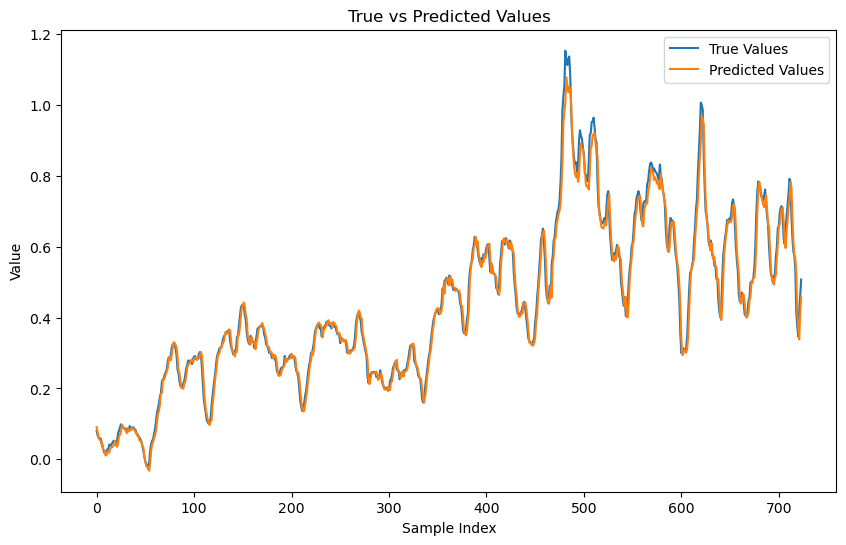

In [599]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.show()

### Future Prediction

In [586]:
def predict_future(model, initial_input, n_steps, look_back):
    future_predictions = []
    current_input = initial_input.clone()  # Start with the last known data

    for _ in range(n_steps):
        # Reshape current_input to match model input requirements (1, look_back, input_features)
        input_for_model = current_input.unsqueeze(0)
        
        # Predict the next value
        with torch.no_grad():
            # next_prediction = model.module_(input_for_model)[0, 0].item()  # Take the scalar value from output
            next_prediction = model(input_for_model)[0, 0].item()  # Take the scalar value from output
        
        # Append the prediction to the future predictions list
        future_predictions.append(next_prediction)
        
        # Update the current input by shifting and appending the new prediction
        next_prediction_tensor = torch.tensor([[next_prediction]], dtype=torch.float32, device='cpu').view(1, -1)

        # Concat next prediction to current input
        current_input = torch.cat((current_input[1:], next_prediction_tensor), dim=0)
    
    return future_predictions
    

# Take the last `look_back` days from X_test as the starting input
look_back = 7  # Example look_back value
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device='cpu')
last_known_data = X_test_tensor[-1]  # Last known sequence (shape: look_back x input_features)
last_date = test_residuals_df.index[-1]

# Predict the next 7 days
future_days = 7
future_predictions = predict_future(model, last_known_data, future_days, look_back)

future_predictions

[0.46358051896095276,
 0.46750175952911377,
 0.47322171926498413,
 0.47900858521461487,
 0.4841616153717041,
 0.48780304193496704,
 0.4908798336982727]

In [587]:
import importlib.util
import sys

module_name = "arima_garch_forecast"
module_path = "/Users/binnu/Library/CloudStorage/OneDrive-student.vgu.edu.vn/VGU/Current Program/Project/Bitcoin Prediction/src/utils/prediction.py"

# Load the module
spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

In [588]:
test_pca_df = pd.read_csv("../data/final/test_pca_df.csv", parse_dates=["Date"], index_col="Date")
val_pca_df = pd.read_csv("../data/final/val_pca_df.csv", parse_dates=["Date"], index_col="Date")
val_exog = val_pca_df.drop(columns=["btc_close"])
test_exog = test_pca_df.drop(columns=["btc_close"])
# concat val and test exog
exog = pd.concat([val_exog, test_exog])

arimax_garch_future = module.arima_garch_forecast(exog, '../models', future_days)

In [589]:
# inverse transform
flat_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Extract last SARIMA-GARCH prediction value in test_residuals_df
last_sarima_garch_prediction = test_residuals_df["SARIMA-GARCH Prediction"].iloc[-1]

final_forecast = flat_predictions +  arimax_garch_future

# final_forecast = np.zeros(len(flat_predictions))

# for i in range(len(flat_predictions)):
#     final_forecast[i] = flat_predictions[i] + last_sarima_garch_prediction

# Undo log-transform 
final_forecast_org = np.exp(final_forecast) - 1

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(final_forecast_org))

# Create the DataFrame
df_predictions = pd.DataFrame({
    "Temporal-Fusion-Transformer": final_forecast_org
}, index=future_dates)

# Rename the index to 'Day' for clarity
df_predictions.index.name = "Date"

# Print the DataFrame
df_predictions

# Save the DataFrame to a CSV file (optional)
# df_predictions.to_csv("future_predictions.csv", index=False)

,Predicted Values
Date,
2024-11-17 00:00:00+00:00,69199.737076
2024-11-18 00:00:00+00:00,68681.501700
2024-11-19 00:00:00+00:00,69366.492009
2024-11-20 00:00:00+00:00,70574.250334
2024-11-21 00:00:00+00:00,71976.633887
2024-11-22 00:00:00+00:00,73199.501429
2024-11-23 00:00:00+00:00,74247.644816


In [590]:
test_pca_df = pd.read_csv("../data/final/test_pca_df.csv", parse_dates=["Date"], index_col="Date")
test_actual_org = np.exp(test_pca_df["btc_close"]) - 1

# Load test prediction npy
test_pred = np.load('../results/predictions/test/lookback7/Temporal-Fusion-Transformer_pred.npy')
test_arima_garch_pred = test_residuals_df["SARIMA-GARCH Prediction"]
final_test_pred = test_arima_garch_pred.iloc[look_back:].values.reshape(-1,1) + test_pred.reshape(-1,1)
final_test_pred_org = np.exp(final_test_pred) - 1

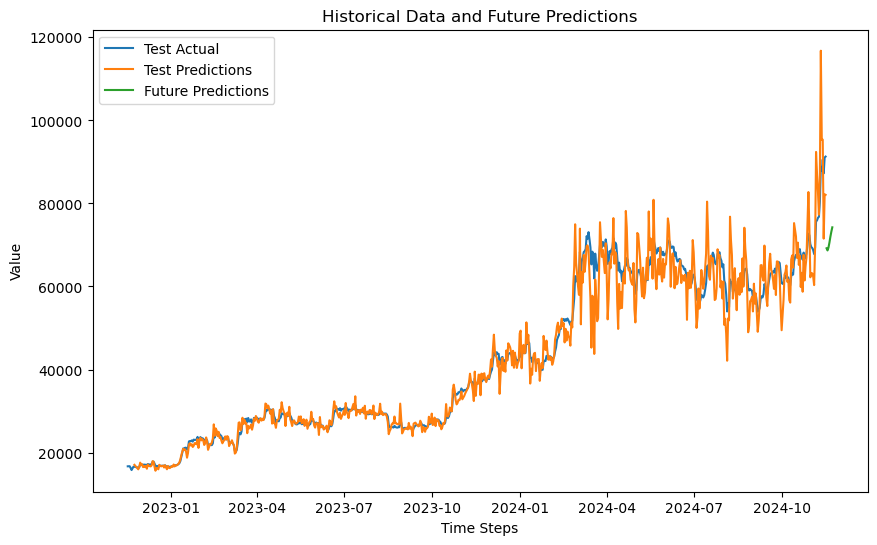

In [591]:
plt.figure(figsize=(10, 6))
plt.plot(test_pca_df.index, test_actual_org, label="Test Actual")
plt.plot(test_pca_df.index[look_back:], final_test_pred_org, label="Test Predictions")
plt.plot(df_predictions.index, df_predictions, label="Future Predictions")
plt.legend()
plt.title("Historical Data and Future Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()